<a href="https://colab.research.google.com/github/barto-official/Audio_Description/blob/main/python/core/Python_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python Data Structures

#Objects

Every runtime entity you can interact with is represented as an **object** with:

* **Identity**: “Which specific object is this?”
* **Type**: “What operations does this object support and what rules does it follow?”
* **Value**: “What does this object represent right now?”

What this implies (practically)

* Names (variables) do not “contain values” like boxes; they **reference objects**.
* Passing arguments passes **object references**.
* Mutation changes an object’s **value**, not its identity.
* Rebinding a name changes which object it references, not the object.

A high-signal mental model is:

> **Name → Object (with id, type, value)**


In Short:
* Variables are named entries in a system table, with spaces for links to objects.
* Objects are pieces of allocated memory, with enough space to represent the values for which they stand.
* References are automatically followed pointers from variables to objects.

##Referencing vs Binding vs Aliasing vs Mutating

**Referencing** is the relationship:

> A name holds a reference (pointer) to an object.

In Python:

* names do not contain values
* names refer to objects

```python
x = [1, 2]
```

Here:

* a list object is created
* `x` references that list

Referencing is passive. Nothing changes; it just describes a relationship.

---

**Binding** —  the *act of associating a name with an object reference*.

```python
x = [1, 2]     # binding
x = "hello"   # rebinding
```

* First line: `x` is bound to a list object
* Second line: `x` is rebound to a string object

Important:

* binding affects names
* binding does not affect objects

Think:

> Binding moves the arrow from the name to an object.

---

**Aliasing** — occurs when multiple names reference the same object.

```python
a = [1, 2]
b = a
```

Now:

* `a` references the list
* `b` references the same list

This is aliasing.

Aliasing is a *property of the object graph*, not an operation.

---

**Mutating** — changes the *internal state (value)* of an existing object.

```python
a.append(3)
```

* the list object changes
* identity stays the same
* all aliases observe the change

Mutation affects objects, not names.

---

The four concepts side-by-side

| Concept     | Acts on        | Changes identity? | Changes value? | Visible to aliases? |
| ----------- | -------------- | ----------------- | -------------- | ------------------- |
| Referencing | Relationship   | No                | No             | N/A                 |
| Binding     | Name           | No                | No             | No                  |
| Aliasing    | Graph property | No                | No             | Yes                 |
| Mutation    | Object         | No                | Yes            | Yes                 |

This table is worth memorizing.

---

**Think in arrows:**

```
name ──► object ──► internal state
```

* Binding: move the arrow from the name
* Referencing: arrow exists
* Aliasing: multiple arrows to same object
* Mutation: change what’s behind the object



##Object Headers

Every CPython object has two broad parts:

1. Header (metadata, uniform across objects)
2. Payload (type-specific fields / data)

The header exists so the interpreter can, for *any* object:

* know its type (method dispatch, protocol behavior, memory management),
* track its lifetime (reference counting, garbage collection),
* treat different objects uniformly via a common prefix. This is classic runtime polymorphism: “common prefix” + “type-specific extension.”

---

**The minimal header: `PyObject`** — The minimal header for a fixed-size object in CPython is conceptually:

* reference count: how many strong references point to this object
* type pointer: what type object describes this object’s behavior

In CPython source terms (conceptual, simplified):

* `ob_refcnt` (a machine word, typically `Py_ssize_t`)
* `ob_type` (pointer to a `PyTypeObject`)

Typical size (64-bit builds)

* `ob_refcnt`: 8 bytes
* `ob_type`: 8 bytes
  → 16 bytes minimum header

Caveat: sizes can vary by build flags and platform, but the *structure* is stable.

---

**Variable-sized objects: `PyVarObject`**

Many objects have a size that varies (e.g., `tuple`, `str`, `bytes`, `int`/`PyLong`). They use an extended header:

* everything in `PyObject`, plus
* length / element count field (`ob_size`)

So conceptually:

* `ob_refcnt`
* `ob_type`
* `ob_size`

Typical size (64-bit builds)

* 16 bytes (`PyObject`) + 8 bytes (`ob_size`)
  → 24 bytes header before any payload

This one field is what makes “variable-length payload trailing in memory” feasible and efficient.

---

**GC-tracked objects: the GC header**

Reference counting alone cannot reclaim cycles (e.g., list A references list B references list A). CPython adds cyclic GC for container-like objects.

For objects that the cyclic GC tracks, CPython stores an additional GC header *before* the normal `PyObject` header in memory.

Conceptually, the GC header stores links needed for GC bookkeeping (e.g., next/prev pointers in GC lists, flags/refs). The exact fields change across versions, but the key point is:

* Some objects are GC-tracked, and thus have extra per-object overhead beyond `PyObject`.

Typical magnitude (64-bit builds)

The GC header is often on the order of a few machine words (commonly ~24 bytes), but treat that as “typical,” not guaranteed.

Which objects are GC-tracked?

* Most containers: `list`, `dict`, `set`, many user-defined class instances (especially if they can participate in cycles)
* Many “leaf” immutable primitives like small `int` objects are typically *not* GC-tracked (they don’t create reference cycles in the same way)

---

Additional “header-like” per-object pointers (type-specific overhead)

Beyond the universal header(s), many object types carry additional pointers that feel “header-ish,” such as:

* a pointer to an instance `__dict__` (for objects with dynamic attributes),
* a pointer for weak references,
* cached hash value (common in strings),
* inline fields for slots, etc.

For example:

* a `list` object contains a pointer to its element array plus size/capacity metadata
* a `dict` object contains pointers to its hash table structure
* an instance of a typical user-defined class often has a `__dict__` pointer (unless `__slots__` is used)

These are not part of the *universal* header, but they are part of the object’s fixed overhead.

---

Memory layout intuition

It is useful to visualize this (not exact bytes, but the conceptual structure):

Non-GC-tracked fixed-size object

```
[ PyObject: refcnt | type* ] [ payload... ]
```

Non-GC-tracked variable-size object

```
[ PyVarObject: refcnt | type* | size ] [ payload... ]
```

GC-tracked object

```
[ GC header ... ] [ PyObject / PyVarObject ... ] [ payload... ]
```

The “common prefix” property means CPython can always do:

* `obj->ob_type` to find the type,
* then use the type’s slots to decide how to compare, hash, iterate, deallocate, etc.

---

**Consequences**

1. Every object has overhead — Even “small” values are not small in memory in CPython because each is a full object with a header.

⚠️ This is a major reason Python containers are pointer-heavy and memory-expensive compared to low-level languages.

2. Containers store pointers to objects, not raw values —  A `list[int]` is not an array of integers; it is an array of pointers to `PyLong` objects. That means:
    * extra indirection (CPU cache misses),
    * much higher memory footprint.

3. Immutability and hashability have real costs/benefits — For example, strings often cache their hash because hashing would otherwise repeatedly traverse payload. That cache is additional per-object state—enabled by immutability.

4. GC tracking adds overhead to containers and instances — This matters when you create huge numbers of short-lived container objects (micro-allocations).

##Memory Overhead

The irreducible minimum: object header cost

In CPython (64-bit, typical build):

**Base object header (`PyObject`)**

* Reference count: 8 bytes
* Type pointer: 8 bytes

→ 16 bytes minimum

This is paid by every object, no exceptions.

---

**Variable-sized object header (`PyVarObject`)**

Adds:

* Size field (`ob_size`): 8 bytes

→ 24 bytes minimum

Used by:

* `int`
* `tuple`
* `str`
* `bytes`
* many others

---

**GC header (for GC-tracked objects)**

Most container and user-defined objects add:

* GC bookkeeping fields (links, flags)

Typically:

* ~24 additional bytes (implementation-dependent)

So a GC-tracked object often starts at ~48 bytes before payload.

---

Scalar objects

**`int`**

* Header + payload
* Typical size: 28 bytes

That’s 28 bytes to represent a number that could fit in 4 or 8 bytes in C.


**`float`**

* Typical size: 24 bytes

**`bool`**

* Singleton objects (`True`, `False`)
* No per-instance overhead beyond the singleton

---



Immutable containers

**`tuple`**

* Header + pointer array
* Cost ≈ 56 bytes + 8 bytes per element

Example:

* Empty tuple: ~56 bytes
* 3-element tuple: ~56 + 24 = 80 bytes

Each element is a pointer to another object, not inline data.

**`str`**

* Header + length + cached hash + character storage
* ASCII string: ~49 bytes minimum
* Unicode storage varies (1–4 bytes per char)

Strings are expensive, but optimized heavily.



**Mutable containers**

**`list`**

* Header + size + capacity + pointer array
* Empty list: ~56 bytes
* Each element: 8-byte pointer
* Over-allocation means unused pointer slots

Example:

* List of 10 ints:

  * list object: ~56 bytes
  * 10 pointers: 80 bytes
  * 10 `int` objects: 280 bytes
    → ~416 bytes total

Logical data: “10 small integers”
Actual memory: hundreds of bytes


**`dict`**

* One of the most memory-heavy objects
* Separate hash table structure
* Sparse allocation for speed

Typical empty dict:

* ~72 bytes, grows quickly

Each key and value is a pointer to an object with its own overhead.


**`set`**

* Similar to dict, but keys only
* Comparable memory cost


**User-defined objects**

**Plain class instance**

```python
class A:
    pass
```

Instance memory includes:

* object header
* GC header
* pointer to `__dict__`
* separate `dict` for attributes

Typical cost:

* ~64–72 bytes for the instance
* ~72+ bytes for the attribute dict

Even an “empty” instance can exceed 150 bytes.

**`__slots__` optimization**

Using `__slots__` removes the per-instance `__dict__`.

This can:

* cut memory by 2× or more
* reduce GC pressure
* improve cache locality

This is a serious optimization lever.

---


**Containers store pointers, not values (critical)**

This is the single biggest source of overhead.

Example:

```python
lst = [1, 2, 3]
```

Memory layout:

* list object
* array of pointers
* each pointer → `int` object
* each `int` object → its own header + payload

This means:

* many allocations
* pointer chasing
* poor cache locality

This is why:

* Python lists are not “arrays”
* NumPy arrays exist
* C extensions matter for performance

---


##Identity

**Identity** is the object’s *distinct existence* during its lifetime. Two objects can have the same type and equal value but still be distinct objects.

In Python, identity is exposed via:

* `is` / `is not`: identity comparisons
* `id(obj)`: a unique integer for the object during its lifetime

Important details

* `is` answers: “Are these two references pointing to the exact same object?”
* `==` answers: “Do these two objects compare equal under their type’s equality rules?”

Example: equality vs identity

* Two separate lists with the same contents are usually `==` but not `is`.
* Two references to the same list are both `==` and `is`.

In [3]:
a = [1,2,3]
b = [1,2,3]
c = a
print(a==b), print(a==c)

True
True


(None, None)

In [4]:
a is b, a is c

(False, True)

`id(obj)`: what it guarantees (and what it does not)
Python guarantees:

1. `id(obj)` returns an integer that is **unique among all live objects** at that moment.
2. That uniqueness holds **for the lifetime of the object**.
3. After an object is destroyed, its `id` value **may be reused** for a different object later.

So the only safe inference is:

* If two objects are alive at the same time, they will not share the same `id`.
* If `id(x) == id(y)` and both are live, then `x is y`.

What it does *not* guarantee

* It does not promise that the number is a memory address (that is an implementation detail).
* It does not promise monotonicity or stability across runs.
* It does not prevent reuse after destruction.

**Id Not necessarily the Memory Address**

In CPython, `id(obj)` is typically the object’s **memory address** (the `PyObject*` pointer value). That is why:

* identity is stable for the object’s lifetime,
* and why `id` reuse can happen once memory is freed and later reallocated.

This is *not* a language guarantee; it’s a CPython implementation detail that is widely relied upon for debugging/inspection, but not for program logic.


Why identity matters for data structures?

* Aliasing: If two names refer to the same mutable container, updates through either name affect the same underlying object.
* ⚠️ Caches and interning: sometimes Python intentionally reuses objects (e.g., small integers, some strings), which can make identity comparisons appear “surprising” if you rely on `is` for value checks.

**Rule:** Use `is` only for identity questions (not “value equality”), except for singletons like `None`.

**Identity surprises — interning and caching**

Identity is not “random.” CPython may reuse objects intentionally:

* **Small integer caching** (common implementation behavior)
* **String interning** (certain strings may be interned)
* Various internal caches

This can make `is` appear to work for “value equality” in toy examples, then fail in real code.

**Rule:** use `is` only for singletons like `None`, `True/False`, and sentinel objects you control.


##Type

The **type** of an object determines:

* What operations are valid (its *behavior*)
* How those operations are executed (methods, slots, protocols)
* The rules for equality, hashing, iteration, containment, numeric behavior, etc.

In Python:

* `type(obj)` returns the object’s type.
* Types are themselves objects (instances of `type` or a metaclass).

Python is **dynamically typed** in the sense that:

* Objects have types.
* Names do not have fixed types; they can be rebound to objects of different types over time.

This matters because the runtime always dispatches behavior based on the object’s type, not the variable name.

Why type matters for data structures:

* The semantics of `==`, `in`, `+`, indexing, iteration, and hashing are all type-defined.
* Subtle bugs often come from misunderstanding type contracts (e.g., assuming an object is hashable, or assuming it is immutable).


```python
type(10) is int
type(int) is type
```

* `int` is an object.
* `list`, `dict`, `function`, `module`, `class` — all are objects.
* `type` is the metaclass that creates most user-defined classes.

This enables:

* runtime introspection,
* metaclasses,
* dynamic class creation,
* decorators that alter class behavior.

----

What a type defines?

1. Operation semantics

    * What does `obj + other` mean?
    * What does `obj == other` mean?
    * What does `obj[i]` mean?
    * What does `for x in obj` do?

2. Mutability rules
    * Can the object change after creation?
    * If so, which operations mutate it?

3. Identity & equality

* Does equality mean structural equality or identity?
* Is hashing allowed?
* If hashable, is the hash stable?

###Dynamic Typing

**1. “Python is dynamically typed (types are checked at runtime)”**

* Values have types; variable names do not have fixed types.

  * In Python, the *object* (the value) carries the type information.
  * A variable name is just a reference to an object and can be rebound to a different type at any time.

```python
x = 10        # x refers to an int
x = "ten"     # now x refers to a str (perfectly valid)
```

* Type correctness is enforced when the code runs, not when it is compiled.

  * Python does not require you to declare types.
  * Many type-related errors only appear when the relevant line executes.

```python
def half(x):
    return x / 2

half(10)      # ok
half("10")    # TypeError at runtime when executed
```

Consequences in practice

1. Faster iteration and flexibility

   * You can write generic code quickly and rely on runtime behavior and tests.
   * Patterns like duck typing (“if it behaves like a sequence, treat it like one”) are idiomatic.

2. Type errors can hide until execution reaches the failing path

   * A function may appear fine until a particular input or branch is used.
   * This increases the importance of tests, especially for edge cases.

3. Refactoring needs more care

   * Because types are not fixed at the variable level, changing how a function is used can break callers in ways that are only caught at runtime.

4. Optional static checking exists, but it is not enforced by the language runtime

   * Type hints (`def f(x: int) -> int:`) help tooling (mypy, pyright, IDEs), but Python will still run even if you violate the hints—unless you add explicit runtime checks.

###Strong Typing

**2. “Python is strongly typed (operations are constrained by type rules)”**

You can perform on an object only operations that are valid for its type.

Python does not silently “coerce” unrelated types to make an operation work.

  * If you try an operation that is not defined between those types, Python raises an error instead of guessing.

```python
"3" + 4
# TypeError: can only concatenate str (not "int") to str
```

* You must explicitly convert when you want a conversion.

```python
int("3") + 4   # 7
"3" + str(4)   # "34"
```

This is the core idea behind “strongly typed” in Python: operations are governed by clear type rules, and Python generally refuses to invent implicit conversions between fundamentally different kinds of values.

Consequences in practice

1. More predictable behavior

   * Errors are raised early at the point of misuse rather than producing a “best guess” result that might be wrong.

2. More explicit code

   * You write conversions intentionally, which makes data handling clearer (e.g., when reading input from text files, JSON, HTTP requests).

3. You rely on protocols / special methods rather than implicit casting

   * If an operation works across types, it is because the types implement compatible methods (e.g., `__add__`, `__mul__`, `__radd__`) or share an interface/protocol, not because the runtime auto-converted them.

4. Polymorphism via behavior (duck typing) — Instead of asking “Is this an instance of type X?”, Python code usually asks:

    * Does it support the operations I need?

Example:

* Anything iterable works in a `for` loop.
* Anything with `__len__` works with `len()`.

This leads to:

* highly generic code,
* fewer rigid hierarchies,
* more composable APIs.

5. Types encode *behavior*, not intent — Type hints are optional and non-enforcing at runtime.

So correctness depends on:

* clear contracts,
* documentation,
* runtime checks when necessary,
* disciplined API design.

In production code, this means:

* you must be explicit about expectations,
* you often validate inputs at boundaries,
* you rely on tests to catch misuse.


6. Refactoring is easier — and riskier:
    * Rename types.
    * Change implementations.
    * Swap one container for another.

Risky:

* Behavior changes silently.
* Performance characteristics change.
* Edge cases shift (e.g., hashability, ordering).

Dynamic typing gives you power, but shifts responsibility to you.


7. Performance trade-offs — Because types are resolved at runtime:

* Python pays dispatch overhead.
* Operations are less predictable for the optimizer.
* You trade raw speed for flexibility.

This drives:

* specialization in hot paths,
* reliance on C extensions (NumPy, pandas),
* careful choice of data structures.

---

**The key difference between “dynamic” and “strong” typing**

These properties describe different aspects:

* Dynamic vs static: *When* type checking happens and whether names have fixed types.

  * Dynamic: mostly at runtime; variables can be rebound to any type.

* Strong vs weak: *How strict* the runtime is about mixing types / implicit conversions.

  * Strong: mixing incompatible types usually raises errors rather than silently coercing.

So Python can be dynamically typed and strongly typed at the same time (and it is).

In [ ]:
## Concrete examples that show both

### Dynamic typing example (re-binding)
x = 1
x = [1, 2, 3]    # fine; x can refer to a list now

### Strong typing example (no implicit coercion)
1 + "2"
# TypeError

### Why some things still “mix” (it is not coercion in the weak-typing sense)
True + 2    # 3


#⚠️
#This works because in Python `bool` is a subclass of `int` (so `True` is essentially `1` in numeric contexts),
#not because Python is loosely converting arbitrary types to make the addition succeed.


##Value

The **value** is what the object represents at a given moment.

* For **immutable** objects (e.g., `int`, `str`, `tuple`), the value cannot change after creation.
* For **mutable** objects (e.g., `list`, `dict`, `set`), the value can change while the identity stays the same.


Consequences:

1. Mutation keeps identity, changes value: Same object, different internal state over time.

2. Rebinding keeps value “conceptually,” changes identity: You may compute a new object with the same apparent value, but it’s a different object.

3. Equality is type-defined; identity is not: Equality is a *behavior*, meaning it can be overridden. Identity is a primitive fact of object existence.


###Equality

1. `is`    — “Are these two references pointing to the same object?”                


Identity is about object existence, not value.

* Every object has exactly one identity during its lifetime.
* Identity does not depend on type semantics or user code.
* Identity is fixed and unambiguous.

When to use it? --> **only** when identity matters.

* Singleton checks:

  ```python
  x is None
  x is True
  x is False
  ```
* Sentinel objects you define:

  ```python
  _MISSING = object()
  if value is _MISSING:
      ...
  ```
* Intentional identity semantics (caches, object pools, flyweights).

**Why this is safe?** These cases rely on object uniqueness, not value equivalence.

⚠️ Don't use it for equivalence: The value may be true depending on:

* interning,
* caching,
* interpreter version.


----

In [6]:
a = "hello"
b = "llohe"
b==a

False

**2. `==` Do these two objects have equivalent values according to their type?”**


```python
a == b
```

* Calls `a.__eq__(b)` (or the reverse if needed).
* Can be overridden.
* May be expensive.
* May return `NotImplemented`.

Equality answers:

> “According to this type’s rules, are these two values equivalent?”


Equality is not universal

Different types define equality differently:

* `int`: numeric equality
* `str`: sequence of code points (order dependent)
* `list`: element-by-element equality
* `dict`: key-value equality (order-independent)
* custom objects: whatever you define



⚠️ Identity DOES imply equality? Not always

For most built-in types:

```python
a is b  ⇒  a == b
```

But this is not guaranteed for all types.

A pathological (but legal) example:

* An object whose `__eq__` always returns `False`.

Identity is a stronger concept than equality.

---

**Equality and hashing**

⚠️

If:

```python
a == b
```

Then:

```python
hash(a) == hash(b)
```

Must be true for the entire lifetime of the object *while it is used as a key*.

Consequences

* Mutable objects are usually unhashable (`list`, `dict`, `set`).
* Immutable objects can be hashable (`tuple`, `frozenset`) *if their contents are hashable*.
* Violating this invariant breaks dict/set correctness.

This is why:

* `list` has `__eq__` but no `__hash__`
* `tuple` has both (conditionally)

---

**3. id()**

Think of three layers:

1. Identity — *semantic*:
   “Are these two names bound to the same object?”

   * checked with `is`

2. `id(obj)` — *representation-level handle*:
   “What is the unique runtime identifier for this object during its lifetime?”

3. Equality — *type-defined semantics*:
   “Do these two objects represent equivalent values?”

`id(obj)` is not a comparison operator. It is an *introspection tool* that exposes identity *indirectly*.

Fundamentally:

```python
a is b    ⇔    id(a) == id(b)
```

This is the only correct logical relationship.

* `is` is the language-level primitive
* `id()` exposes the identity token as an integer

---

Python already has `is`, so why expose `id()`?

Because `id()` is useful for:

* debugging aliasing,
* inspecting object graphs,
* understanding lifetime and reuse,
* low-level diagnostics,
* teaching the object model.

It is not meant for application logic.

Id() is not a persistent object ID

```python
x = object()
x_id = id(x)
del x

y = object()
# y may reuse x_id
```

After an object is destroyed, its `id` may be reused.
So `id()` is not stable across time, only across *lifetime*.

---

⚠️ Not portable across implementations

* CPython often uses the memory address.
* Other Python implementations may not.
* The language only promises uniqueness among live objects.

So `id()` must never be treated as:

* a memory address you can reason about,
* a serialization key,
* a database ID,
* a cache key beyond immediate debugging scope.



#### `__eq___`

You can override `__eq__`, but you cannot override `is` or `id()`.

Reason:

* Identity must be absolute and unambiguous
* It underpins garbage collection, reference counting, and correctness.

You can define structural equality:

```python
class Point:
    def __eq__(self, other):
        return isinstance(other, Point) and self.x == other.x and self.y == other.y
```

What you must then consider:

* Should it be hashable?
* Is it mutable?
* Does equality change over time?
* Does equality respect symmetry and transitivity?

Mistakes here cause:

* broken sets,
* disappearing dict keys,
* hard-to-debug logic errors.


Practical rules you should adopt early

1. **Use `is` for identity checks only**, especially for `None`:

   * `x is None` is correct; `x == None` is not a best practice.

2. **Assume aliasing whenever you share mutable objects**

   * If you pass a list into a function, both caller and callee can mutate the same object unless you copy.

3. **Treat “value” for mutables as state**

   * This framing helps you reason about bugs involving shared containers.

4. **Never rely on object identity for values**

   * Interning/caching can mislead you; use `==` for value equality.


Quick introspection checklist (no heavy tooling yet)

* Identity: `id(x)`, `x is y`
* Type: `type(x)`, `isinstance(x, SomeType)`
* Value (conceptual): depends on type; for containers inspect contents; for objects inspect attributes.

How __eq__ is implemented?

When Python evaluates:

```python
a == b
```

it proceeds in this order:

1. Call `a.__eq__(b)`
2. If that returns `NotImplemented`, call `b.__eq__(a)`
3. If both return `NotImplemented`, fall back to:

   * `False` for `==`
   * `True` for `!=`

This is specified by Python’s data model and implemented in the CPython interpreter.

---

Signature and contract of `__eq__`

```python
def __eq__(self, other):
    ...
```

Key rules:

* Must return:

  * `True` or `False`, or
  * `NotImplemented` if the comparison is unsupported
* Should **not raise** `TypeError` for unsupported types (return `NotImplemented` instead)
* Should be **reflexive, symmetric, and transitive** when possible

---

Default behavior (object.**eq**)

If you do **not** define `__eq__`, your class inherits:

```python
object.__eq__(self, other)
```

This is effectively:

```python
self is other
```

Meaning:

* Equality is **identity-based**
* Two distinct instances are never equal unless they are the same object in memory

Example:

```python
class A:
    pass

A() == A()   # False
```

---

Typical user-defined implementation

A common pattern:

```python
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return self.x == other.x and self.y == other.y
```

Important details:

* `isinstance` check ensures type compatibility
* `NotImplemented` allows Python to try the reverse comparison
* Attribute-by-attribute comparison defines semantic equality

---

Interaction with `__hash__`

This is critical:

* If you **override `__eq__`**, Python automatically sets:

  ```python
  __hash__ = None
  ```
* This makes instances **unhashable** (cannot be used in `set` or as `dict` keys)

Reason:

* Hash-based collections require that:

  ```text
  a == b  ⇒  hash(a) == hash(b)
  ```

If you want hashability:

```python
class Point:
    def __eq__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return (self.x, self.y) == (other.x, other.y)

    def __hash__(self):
        return hash((self.x, self.y))
```

---

How built-in types implement `__eq__`

Examples conceptually (simplified):

Integers

```python
int.__eq__(a, b)
# compares numeric value
```

Strings

```python
str.__eq__(a, b)
# length check → character-by-character comparison
```

Lists

```python
list.__eq__(a, b)
# same length → element-wise __eq__
```

If any element comparison returns `False`, the result is `False`.

---

Why `NotImplemented` matters

Incorrect implementation:

```python
def __eq__(self, other):
    return False
```

Correct implementation:

```python
def __eq__(self, other):
    if not isinstance(other, MyClass):
        return NotImplemented
    ...
```

Returning `False`:

* Silently breaks symmetry
* Prevents reverse comparison
* Produces incorrect results in mixed-type comparisons


##Hashability

In [12]:
a="hello"
b="hello"
a==b

True

In [13]:
a is b

True

In [14]:
b is a

True

In [15]:
hash(a)

-1172089579261806605

In [16]:
hash(b)

-1172089579261806605

In [17]:
hash(a) == hash(b)

True

Hashing exists to support **hash-based containers**:

* `dict`
* `set`
* `frozenset` (internally)

These data structures rely on a **hash table** whose correctness depends on very strict contracts.

Fundamentally:

> **If `a == b`, then `hash(a) == hash(b)` must be true.**

The converse is **not required**:

* `hash(a) == hash(b)` does *not* imply `a == b`.

> *Equality defines sameness; hashing requires that sameness never change.*


---

**Why hash stability is required?**

When you insert a key into a `dict`:

1. Python computes `hash(key)`.
2. It uses that hash to choose a bucket.
3. It stores the key-value pair there.
4. On lookup, Python:

   * recomputes `hash(key)`,
   * goes to the same bucket,
   * then uses `==` to confirm the key matches.


The hash of the key **must not change** while the key is in the table.

----

**Why immutability is required for hashable objects?**

Because:

* Hash stability over time requires that the data used to compute the hash **cannot change**.
* That means the object must be **immutable**, or at least *effectively immutable*.

* Mutable built-ins are **unhashable**:

  * `list`
  * `dict`
  * `set`
* Immutable built-ins are **hashable**:

  * `int`
  * `str`
  * `tuple` (if elements are hashable)
  * `frozenset`


---

If immutable objects were not hashable, Python would be forced to:

* use linear search (O(n)) instead of hash lookup (O(1) average)

* rely on equality comparisons only

This would severely degrade performance across the language.


----


When to make objects hashable:

* Immutable value objects
* Configuration keys
* Identifiers
* Structural records that never change

When to forbid hashing:

* Mutable domain objects
* Objects with lifecycle/state changes
* Anything with “update” methods

Recommended patterns:

* Use `frozen` dataclasses for value objects
* Keep mutable objects out of `dict` keys
* Use explicit IDs (UUIDs) when identity matters



Python enforces safety by default.

Rule 1: Override `__eq__` → hash disabled

If you define `__eq__` but do not define `__hash__`, Python sets:

```python
__hash__ = None
```

Meaning:

* instances are **unhashable**
* cannot be dict keys or set members

This prevents accidental invariant violations.

<br>

Rule 2: Identity-based hashing by default

If a class does **not** override `__eq__`:

* equality defaults to identity,
* hash defaults to identity-based hash.

So:

* `a == b` only if `a is b`,
* `hash(a)` remains stable,
* hashability is safe even for mutable objects.

<br>


---

Built-in examples that encode these rules

| Type        | Mutable | `__eq__`    | `__hash__`        | Hashable |
| ----------- | ------- | ----------- | ----------------- | -------- |
| `int`       | No      | Value-based | Yes               | Yes      |
| `str`       | No      | Value-based | Yes               | Yes      |
| `tuple`     | No      | Structural  | Yes (conditional) | Yes      |
| `list`      | Yes     | Structural  | None              | No       |
| `dict`      | Yes     | Structural  | None              | No       |
| `set`       | Yes     | Structural  | None              | No       |
| `frozenset` | No      | Structural  | Yes               | Yes      |

This table is *not accidental*. It is a carefully engineered safety policy.

---


###Identity-hashing vs Value-hashing

Identity-based —  In CPython, the default `__hash__` is usually based on `id(obj)`.

* Even if the object’s internal state changes, its identity does not:

Where Python uses this

* Most user-defined classes by default
* Objects intended to be **containers, managers, or stateful entities**
* Any mutable object without a custom equality definition

---

Value-based hashing

* **Equality:** Based on object *contents* (`__eq__`)
* **Hash:** Derived from the same contents
* **Mutability:** Must be **immutable**
* **Typical use:** Value objects (numbers, strings, tuples, frozen data)


Note (!):
* Immutable built-in types → value-based hashing
* Mutable built-in types → unhashable
* User-defined objects → identity-based by default

Example: built-in immutable types

```python
a = (1, 2, 3)
b = (1, 2, 3)

a == b              # True
hash(a) == hash(b)  # True
```

Here:

* Equality is semantic (values match)
* Hash is computed from contents
* Objects can safely be dictionary keys or set members

---

How Python chooses between the two

| Situation                          | Equality    | Hashing        | Result     |
| ---------------------------------- | ----------- | -------------- | ---------- |
| No `__eq__` override               | Identity    | Identity-based | Hashable   |
| `__eq__` overridden, no `__hash__` | Value-based | Disabled       | Unhashable |
| `__eq__` + `__hash__` consistent   | Value-based | Value-based    | Hashable   |
| Immutable built-in types           | Value-based | Value-based    | Hashable   |

---

Design guidance in Python

* **Use identity-based hashing** when:

  * Objects are mutable
  * Identity matters more than state
  * Objects represent entities, resources, or lifecycles

* **Use value-based hashing** when:

  * Objects are immutable
  * Objects represent pure data
  * Equality should reflect meaning, not identity

A useful heuristic:

> If changing any attribute would conceptually create a *different* object, use value-based hashing and enforce immutability.

##Object lifetime

An object remains alive as long as something holds a **strong reference** to it. In practice, references come from:

* local variables (stack frame references),
* globals / module variables,
* container contents (lists, dicts, sets, tuples),
* closures,
* instances referencing other objects,
* caches / interning mechanisms.

When the last strong reference goes away, the object becomes collectible.

CPython primarily uses:

1. Reference counting (immediate reclamation in many cases)

Each object maintains a reference count. When it drops to zero, the object is usually deallocated immediately.

Implication: in CPython, many objects are destroyed deterministically (often right when they become unreachable), but you should not write logic that depends on that determinism.

2. Cyclic garbage collector (for reference cycles)

Reference counting alone cannot reclaim cycles like:

* `a -> b -> a`

CPython’s cyclic GC periodically finds unreachable cycles and collects them.

Implication: objects involved in cycles may live longer than you expect, even if they are no longer reachable from your program’s roots.

---

Because `id()` values can be reused after an object is freed, patterns like this are unsafe:

* Logging or caching based on `id(obj)` as a long-term stable identifier
* Persisting `id()` across time and expecting it to refer to “the same object later”

A common debugging pitfall:

```python
x = object()
x_id = id(x)
del x

y = object()
# y may (rarely but legitimately) reuse x's old id in CPython
```

This is not guaranteed to happen, but it is allowed.



**Lifetime and finalization**

`__del__` pitfalls (important in production)

* Finalization timing is not guaranteed across Python implementations.
* Even in CPython, cyclic GC + finalizers can produce surprising behavior.
* During interpreter shutdown, module globals may already be partially torn down, so `__del__` can fail in odd ways.

**Safer patterns**

* Use context managers (`with`) for deterministic cleanup (files, locks, network connections).
* Use `weakref.finalize` when you need a callback on object collection without `__del__`’s sharp edges.

##Name binding vs Object Mutation

**Same operator, different meaning depending on type**

Many operators are defined by the type. For sequences, this is especially important:

Example: `+=` may mutate or rebind depending on mutability / implementation

* For `list`, `xs += [1]` typically mutates in place (via `__iadd__`).
* For `tuple`, `xs += (1,)` must create a new tuple (rebinding), because tuples are immutable.

You should treat “in-place” operators as: “mutate if possible; otherwise allocate new.”

**Avoid representation exposure**

Do not return internal mutable containers directly unless you want callers to mutate your internal state.

Instead:

* return an immutable view (tuple, frozenset),
* or return a defensive copy,
* or provide query methods.

**Defensive copying: know what problem you’re solving**

* If you need isolation from caller mutation, copy at the boundary.
* If you need performance, avoid deep copies; consider immutability or controlled mutation.


##Reference vs Value Semantics

Reference semantics — A variable (name) holds a **reference to an object**. Assignments and argument passing copy the reference, not the object.

Value semantics —  A variable “contains” the value itself (or behaves as if it does). Copying/assignment produces an independent value.

Implications:

* Two variables with the “same value” are independent.
* Mutating one does not affect the other (because they are distinct values).

Many languages have strong value semantics for primitives/structs. Python largely does not—except you can *simulate* value semantics with immutability + disciplined copying.

**Python’s model** — “reference semantics for objects”
* Names refer to objects.
* Passing arguments passes references.
* Assignment rebinds names to objects.

Why immutables feel like value semantics?

Immutable objects (e.g., `int`, `str`, `tuple`, `frozenset`) cannot be mutated, so aliasing is not dangerous.

```python
x = 10
y = x          # reference copied, but ints are immutable
y = y + 1      # creates a NEW int and rebinds y

# x is still 10
```

This *looks* like value semantics, but what actually happened is:

* you never mutated `10` (you can’t),
* you created a new object and rebound `y`.

So immutability provides “value-semantics-like” behavior even in a reference-semantics object model.

----

**Copying** — the sharpest practical difference

If you want independence, you create a new object.

* Shallow copy: new container, same element references
* Deep copy: new container plus recursively copied contents

Example (shallow copy pitfall):

```python
a = [[1], [2]]
b = list(a)          # shallow copy

b[0].append(99)      # mutates the inner list object

# a is now [[1, 99], [2]] because inner lists were shared
```

This is the most common “I copied it but it still changed” bug.

---

API design framing: ownership and escape analysis:

When you pass a mutable object across a boundary, you must decide:

* Do I take ownership? (I may mutate it)
* Do I borrow it read-only? (I promise not to mutate)
* Do I snapshot it? (I copy it to avoid aliasing)
* Do I return internal state? (representation exposure risk)


In [27]:
### IMPORTANT EXAMPLE

a = [1,2]
b = a # b does not point to 'a' but to the object that 'a' is referencing

print(a==b), print(a is b)

True
True


(None, None)

In [29]:
a="hello"

hello [1, 2]


In [32]:
a,b #b points to [1,2]

('hello', [1, 2])

In [33]:
#However

a = [1,2]
b= a

a[0]=33

In [34]:
b #changes in place

[33, 2]

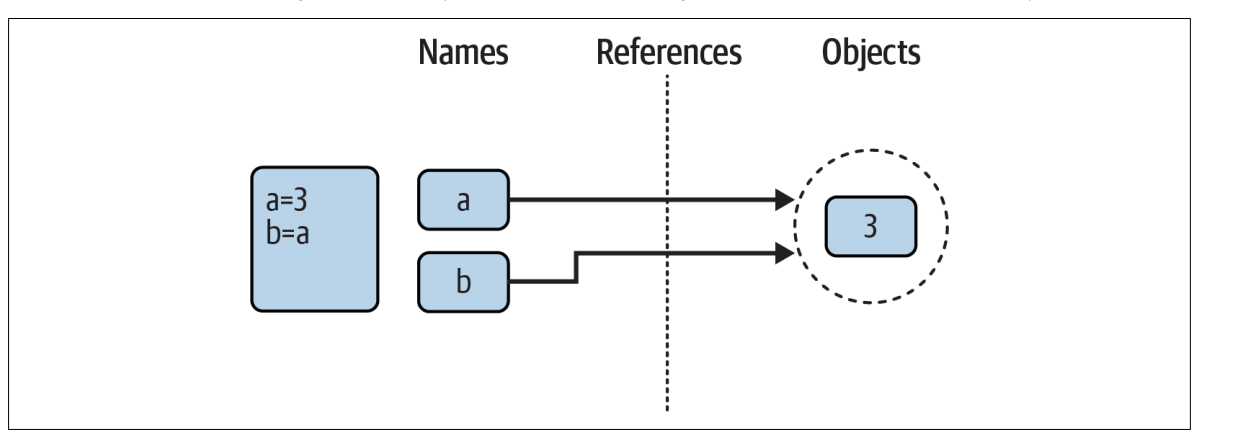

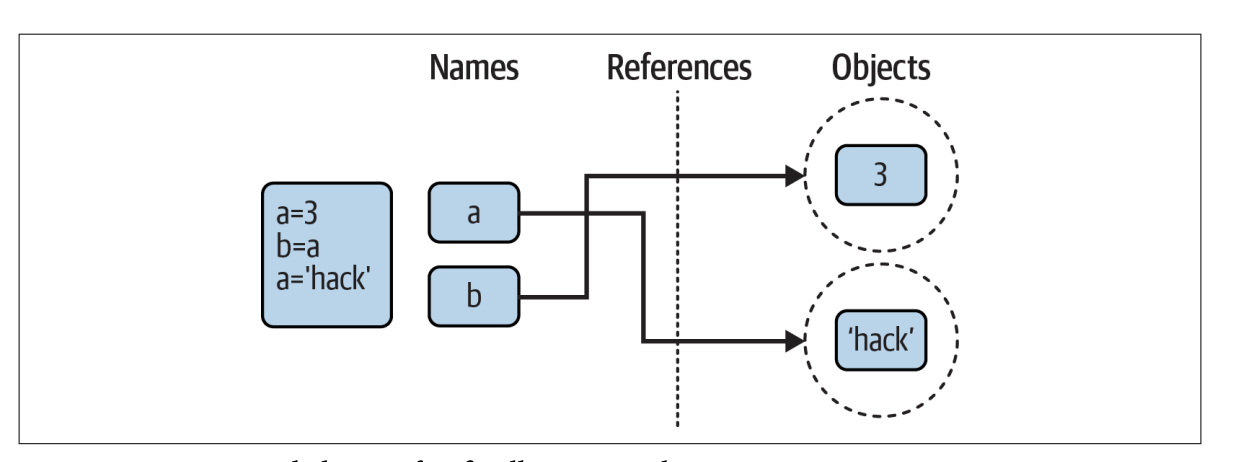

Immutability is a property of the object. Rebinding is a property of the name.

##Augmented Operators

Augmented assignment operators: (`+=`, `*=`, `|=`, etc.)

What they do:

> “Try to update the object referred to by `x` *in place*;
> if that is not possible, compute a new value and rebind `x`.”

A. Path A — In-place mutation (if supported)

* Calls an *in-place* method (e.g. `__iadd__`)
* Object identity is preserved
* Aliases see the change

B. Path B — Rebinding (fallback)

* Computes a new object (e.g. via `__add__`)
* Rebinds the name
* Aliases do **not** see a change

Which path is taken depends entirely on:

* the object’s **type**
* whether it supports in-place mutation

**⚠️ Key Difference**

```python
lst += [x]  #in place mutation for mutable, copy for immutable
#vs
lst = lst + [x] #create new object + rebinding
```

In [68]:
t=(1,2)
type(t)

tuple

In [69]:
t[1]=0 #normal behavior

TypeError: 'tuple' object does not support item assignment

In [70]:
#however
t = (1, [1,2])
t[1]=0

TypeError: 'tuple' object does not support item assignment

In [71]:
t[1].append(0)

In [72]:
t

(1, [1, 2, 0])

In [77]:
#however x2
t = (1, [1,2])
type(t)

tuple

In [80]:
t[1] += [0]

TypeError: 'tuple' object does not support item assignment

In [81]:
#but
t #0 is here?

(1, [1, 2, 0])

This **does** assign to a list because the expression on the right is evaluated first (add to the list) and then add to the tuple. Becuase it was already assigned to the list, the object is there extended. Now, tuple prints error but it points to the already extended object.

#Immutability

In [35]:
x = 99
y = 99

x==y

True

In [36]:
x is y

True

Why? Caching for integers.

In [37]:
x = "Hello World"
y = "Hello World"

x is y

False

In [41]:
import sys
sys.getrefcount(x)

2

2 because:

reference count = actual references + 1 (temporary reference from getrefcount)


Definitions:

> After an object is created, its **observable value** cannot be changed through any operation.

> An object is immutable if there is no sequence of Python-level operations that can change the result of observing its value through its public interface, after it has been created.
⚠️

Immutability is a property of the object.
Rebinding is a property of the name.

---

“Value” is defined by the **type’s semantics** (its contract).

Examples:

* For `int`, “value” is the number.
* For `str`, it is the sequence of characters.
* For `tuple`, it is the sequence of element references.
* For a frozen dataclass, it is the set of fields.

So immutability means: operations cannot change whatever the type considers its value.


Why immutability matters


1. With immutable objects, the meaning of an object is **time-invariant**. This enables:

* referential transparency (at the object level),
* local reasoning (you don’t need global knowledge),
* easier debugging (state does not “drift”).


2. Immutability neutralizes aliasing:

* shared references are safe,
* returning internal state is safe,
* caching is safe,
* passing values across layers is safe.

This is why immutable value objects are preferred at **module boundaries** and **API surfaces**.


3. Concurrency and parallelism — Concurrency bugs usually come from shared mutable state, uncontrolled mutation order, partial updates.

Immutability eliminates entire classes of bugs:

* no race conditions on immutable data,
* no need for locks to protect read-only data,
* safe sharing across threads and tasks.

In Python specifically:

* the GIL does *not* eliminate logical races,
* async code has interleavings just like threads,
* immutability provides correctness independent of execution model.

----

4. Hashing, caching, and memoization

Immutable objects:

* have stable equality,
* have stable hash,
* are safe dict keys and set members.

This enables:

* memoization,
* LRU caches,
* deduplication,
* interning,
* safe configuration keys.

Mutable objects sabotage all of these unless you add discipline and defensive copying.

---

5. Architectural clarity — Immutability enforces a clean separation:

* **data** (immutable values)
* **behavior** (functions that produce new values)

This leads to:

* clearer data flow,
* easier testing,
* fewer hidden dependencies.

This is why immutable data is often preferred in:

* config systems,
* event models,
* message passing,
* pipeline stages.

##Performance

When it hurts performance?


1. Allocation and copying costs —mImmutable updates require:

* allocating new objects,
* copying existing data,
* increasing GC pressure.

Example:

```python
t = t + (x,)
```

This:

* allocates a new tuple,
* copies all existing elements,
* creates new references.

For small objects, this is cheap.
For large objects, this is disastrous.

----

2. Memory overhead amplification

Python objects already have large overhead:

* object headers,
* pointer indirection,
* GC tracking.

Immutability often multiplies this overhead:

* many short-lived objects,
* duplicated data graphs,
* poor cache locality.

This is why:

* large immutable trees in Python can be slow,
* naïve functional patterns do not scale.

---

3. Hot loops and incremental updates — In performance-critical code:
    * incremental updates to mutable structures are much cheaper.

Example:

```python
# mutable
lst.append(x)

# immutable
lst = lst + (x,)   # O(n)
```

If this is in a hot loop:

* immutable version is catastrophically slower.

---

5. Large data structures and partial updates

Immutable structures force:

* whole-structure replacement,
* even when only a small part changes.

In languages with **persistent data structures**, this cost is amortized via structural sharing.

Python does *not* have native persistent collections.

So immutability in Python often means:

* O(n) copies,
* memory churn,
* GC overhead.

---

6. Interaction with Python’s object model

Because:

* containers store pointers,
* values are heap-allocated,
* GC tracks many objects,

immutability can:

* worsen cache behavior,
* increase pointer chasing,
* increase memory fragmentation.

---


**When to use immutability?**

* correctness and clarity dominate,
* data crosses boundaries,
* data is shared widely,
* ⚠️ data is read much more than written,
* objects are small to medium sized,
* hashing or caching is needed.

Prefer mutability when:

* performance is critical,
* updates are frequent and incremental,
* data is large,
* ownership is clear,
* mutation is localized and controlled.

---

**Hybrid patterns**

Most real systems use hybrids:

* Immutable *interfaces*, mutable *internals*
* Mutable builders → immutable snapshots
* Immutable config → mutable runtime state
* Value objects around mutable engines

Example:

* build a list mutably,
* convert to tuple for external use.

This gives:

* performance during construction,
* safety during use.


##Shallow vs Deep

**Structural immutability vs deep immutability**

Python’s immutability is often **shallow**.

1. An object is structurally immutable if:
    * its own structure cannot change,
    * but it may reference mutable objects that can change.

Classic example: `tuple`

A tuple cannot change which objects it references, but if it references a mutable object, that mutable object can change:

* tuple structure stays the same
* the overall “meaning” you might associate with it can still evolve because nested objects mutate

So: the tuple is immutable, but the referenced graph may not be.


In [18]:
a = [1,2,3]
b = (a, 1,2)


In [19]:
a

[1, 2, 3]

In [20]:
b

([1, 2, 3], 1, 2)

In [23]:
id(a)

133688571973632

In [22]:
for i in b: print(id(i))

133688571973632
11654376
11654408


In [24]:
a.append(4)

In [25]:
a

[1, 2, 3, 4]

In [26]:
b

([1, 2, 3, 4], 1, 2)

**2. Deep immutability**

Deep immutability means:

* the object is immutable,
* and everything reachable from it is also immutable.

⚠️ In Python, deep immutability is a *design discipline*, not a built-in guarantee (except for certain types/graphs).

This distinction matters directly for:

* hashability
* safe sharing
* concurrency
* caching

---

**What immutability prevents**

* In-place modification of state
* Accidental aliasing side effects (for that object)
* Hash instability (for truly immutable values)
* Many classes of concurrency bugs

**What immutability does not prevent**

* Rebinding variables to different objects
* Mutating objects referenced *by* an immutable container (shallow immutability)
* Observing “different results” due to external state (time, I/O, globals)
* Mutating internal state hidden behind the API (types can cheat, though well-designed ones do not)

---

Immutability in Python is enforced by **type design**, not by a universal language rule.

Examples:

* `int` has no operations that mutate it; arithmetic creates new ints.
* `str` has no operations that mutate characters; methods return new strings.
* `tuple` has no methods to replace elements.
* `frozenset` has no methods to add/remove members.

In other words:

> An “immutable type” is a type that does not expose mutating operations and whose internal implementation does not allow user-observable mutation.

---

**Why immutability is so important**

Immutability is the cleanest way to solve:

* aliasing and unintended side effects,
* safe sharing across boundaries,
* stable hashing and dict/set correctness,
* cache keys and memoization,
* predictable behavior under concurrency.

⚠️ In Python, because names are references and containers store references, immutability becomes a primary tool for controlling complexity.


##Truly vs Effectively Immutable

In Python, immutability is **not a single binary property**. It exists at multiple layers:

* language-level guarantees,
* type-level guarantees,
* behavioral guarantees enforced by convention.

As a result, two different notions emerge:

1. **Truly immutable** (enforced, absolute)
2. **Effectively immutable** (guaranteed by discipline and design)



----

An object is truly immutable if there exists no Python-level operation that can change its observable value after creation.

This is a strong guarantee, enforced by the type’s implementation, not by user discipline.
* No mutating methods exist
* Internal state cannot be reassigned
* Equality is stable forever
* Hash is stable forever
* Safe to share globally
* Safe as dict/set keys
* Safe across threads, async tasks, caches

Examples

* `int`
* `float`
* `bool`
* `None`
* `str`
* `bytes`
* `frozenset`
* `tuple` (structure only; see below)
* frozen `@dataclass`
* classes with no mutation paths and no mutable substructure


*tuples are only *structurally* immutable*

```python
t = ([1, 2], [3, 4])
```

* The tuple cannot change its elements
* But the elements themselves can mutate

So:

* the tuple object is truly immutable
* the object graph reachable from it may not be

This matters for hashing and deep correctness.

---

----


An object is effectively immutable if it is technically mutable, but by design and contract, its state never changes after a certain point.

Immutability here is a discipline, not a guarantee.
* May have mutating methods
* May contain mutable fields
* Mutation is disallowed by convention or lifecycle rules
* Equality and hash are assumed stable
* Correctness depends on programmer discipline

This is extremely common in performance-sensitive Python code.

Examples

“Frozen-by-convention” objects

* Configuration objects loaded at startup
* Parsed schemas
* Metadata objects
* AST nodes after construction
* ORM entities after persistence

Lifecycle-based immutability

```python
builder = ConfigBuilder()
builder.set_timeout(5)
builder.set_retries(3)
config = builder.freeze()   # after this: no mutation
```

Before `freeze`: mutable
After `freeze`: effectively immutable

Python allows it because it prioritizes:
* performance,
* flexibility,
* incremental construction,
* low allocation overhead.

Enforcing true immutability everywhere would be prohibitively expensive.


----

**Hashing is where the distinction becomes critical**

Truly immutable

* Hashability is safe
* Hash never changes
* Can be used as dict/set keys unconditionally

Effectively immutable

* Hashability is conditionally safe
* Only safe if immutability is strictly respected
* Any accidental mutation corrupts hash tables

This is why Python defaults to:

* disabling hashing when value-based equality is defined
* forcing you to opt in consciously

---

**Heuristics**

Use truly immutable when:

* object is a value object
* object will be hashed or cached
* object crosses thread/process boundaries
* object is shared widely
* correctness dominates performance

Use effectively immutable when:

* performance is critical
* object is large
* object has a clear construction phase
* mutation is tightly controlled
* object is not used as a hash key

Avoid:

* hashing effectively immutable objects
* relying on “everyone knowing not to mutate”
* exposing internals of effectively immutable objects


#Copying

A Python “value” is an **object graph**:

* objects are nodes,
* references are edges.

Operations like assignment and copying determine:

* which nodes are new,
* which edges are shared,
* where aliasing remains.

Keep this invariant in mind:

> Copying is not “copying data”; it is “choosing what parts of the object graph to duplicate vs share.”

---


A **shallow copy** creates a new *outer* object, but the inner referenced objects are shared.

Common shallow-copy operations:

* `list(x)`, `x[:]`, `x.copy()`
* `dict(x)`, `x.copy()`
* `set(x)`, `x.copy()`
* `copy.copy(x)`

Example:

```python
import copy
a = [[1, 2], [3, 4]]
b = copy.copy(a)
```

Now:

* `a is b` → False (different outer list)
* `a[0] is b[0]` → True (same inner list objects)

Mutation behavior:

* Mutating the outer container does not affect the other:

  * `b.append(...)` affects only `b`
* Mutating a shared inner object affects both:

  * `b[0].append(99)` affects `a[0]` too

When shallow copy is correct

* When the children are immutable, or treated as read-only
* When you want to duplicate structure but share elements safely
* When performance/memory ma

---


A **deep copy** recursively copies the object and (by default) everything reachable from it.

```python
import copy
a = [[1, 2], [3, 4]]
b = copy.deepcopy(a)
```

Now:

* `a is b` → False
* `a[0] is b[0]` → False
* Mutating any nested part of `b` does not affect `a`

Deep copy is appropriate when you truly need **full isolation**:

* you will mutate deeply nested structures,
* you cannot control aliasing,
* you need a “snapshot” safe from any internal mutation.

Why deep copy is risky

* potentially very expensive (time and memory)
* may copy far more than intended
* can break identity-based semantics
* can fail or misbehave with external resources (locks, files, sockets)
* must handle cycles (which it does via memoization, but semantics can still surprise)

In production systems, `deepcopy` is often a smell unless used intentionally and sparingly.


---

**Copying nested data structures — Selective Copy Pattern**

**Pattern 1:** Shallow copy the outer container and deep copy only the parts from the inside that you know you will use.


**Pattern 2:** In real systems you usually know *which path* you will mutate.

Example idea:

* you have a dict-of-dicts
* you want to update one nested leaf
* you copy only along the path (outer dict + that nested dict), not everything

This gives you:

* predictable isolation
* much lower cost than deep copy
* clearer intent

This is Python’s practical substitute for persistent data structures.


**Pattern 3**: If nested components are immutable (or made immutable), shallow copy becomes safe and often unnecessary.

Typical pattern:

* build nested structure mutably
* convert to tuples/frozensets/frozen value objects
* then share freely and shallow copy only the outer shell if needed

---


Decision Framework:

1. **What must be isolated?**

   * only the outer container?
   * a specific nested subtree?
   * the whole graph?

2. **Is mutation required?** --> If not, don’t copy; freeze or treat as read-only.

3. **Where is the boundary?** — Copy at boundaries, not everywhere.

4. **What is the cost budget?** — If in hot paths, avoid deep copies and repeated shallow copies.

---


Examples:

Case: list of lists

```python
a = [[1, 2], [3, 4]]
b = list(a)   # shallow
```

* `b` is a new list
* but `b[0]` and `a[0]` refer to the same inner list

Mutation leak:

* modifying `b[0]` affects `a[0]`

**Correct strategies**

* if you need full independence: deep copy
* if you mutate only one inner list: copy just that one inner list


Case: dict with nested dict/list values

```python
a = {"x": {"y": 1}, "z": [1, 2]}
b = dict(a)   # shallow
```

* top-level keys are copied into a new dict
* nested dict/list objects are shared

**Correct strategies**

* deep copy only the nested paths you will mutate
* or freeze nested structures (immutability) to make shallow copy safe

In [ ]:
## Pattern 1 — Shallow copy the outer container, deep copy only the parts you will use

### Example: Configuration object with mutable sub-sections

import copy

def update_logging_config(config: dict) -> dict:
    # Shallow copy the outer structure
    new_config = config.copy()

    # Deep copy only the part we intend to mutate
    new_config["logging"] = copy.deepcopy(config["logging"])

    # Safe mutation
    new_config["logging"]["level"] = "DEBUG"

    return new_config


original = {
    "db": {"host": "localhost", "port": 5432},
    "logging": {"level": "INFO", "handlers": ["console"]},
}

updated = update_logging_config(original)

assert original["logging"]["level"] == "INFO"
assert updated["logging"]["level"] == "DEBUG"
assert original["db"] is updated["db"]  # intentionally shared



In [ ]:
## Pattern 2 — Copy only along the mutation path

### When this is appropriate

### Example: Updating a deeply nested leaf

def update_user_email(state: dict, user_id: str, new_email: str) -> dict:
    # Copy the outermost container
    new_state = state.copy()

    # Copy only the path we mutate
    users = new_state["users"] = state["users"].copy()
    user = users[user_id] = state["users"][user_id].copy()

    # Perform the mutation
    user["email"] = new_email

    return new_state


state = {
    "users": {
        "u1": {"email": "a@example.com", "role": "admin"},
        "u2": {"email": "b@example.com", "role": "user"},
    },
    "version": 1,
}

new_state = update_user_email(state, "u1", "new@example.com")

assert state["users"]["u1"]["email"] == "a@example.com"
assert new_state["users"]["u1"]["email"] == "new@example.com"

assert state["users"]["u2"] is new_state["users"]["u2"]  # shared


### Why this is powerful

#* Only O(depth) copying.
#* Extremely predictable isolation boundaries.
#* Clear mutation intent.
#* This is exactly how Redux, Clojure, and functional lenses work conceptually.

### Optional refinement: helper for path copying

def copy_path(root, *keys):
    current_old = root
    current_new = root.copy()
    out = current_new

    for key in keys[:-1]:
        child_new = current_old[key].copy()
        current_new[key] = child_new
        current_old = current_old[key]
        current_new = child_new

    return out


In [ ]:
## Pattern 3 — Make nested components immutable

### When this is appropriate

#* Nested components should never change after creation.
#* You want to share aggressively and safely.
#* You want shallow copies (or no copies) to be correct.

### Example: Build mutably, freeze for sharing

from dataclasses import dataclass

@dataclass(frozen=True)
class User:
    id: str
    email: str
    roles: tuple


def build_users():
    users = []
    users.append(User("u1", "a@example.com", ("admin",)))
    users.append(User("u2", "b@example.com", ("user",)))
    return tuple(users)


users = build_users()

state1 = {"users": users, "version": 1}
state2 = state1.copy()  # safe shallow copy

assert state1["users"] is state2["users"]


### Example: Freezing nested dicts

def freeze_config(cfg: dict) -> tuple:
    return tuple(sorted(cfg.items()))


config = {
    "timeout": 30,
    "retries": 3,
}

frozen_config = freeze_config(config)

state = {"config": frozen_config}


### Why this works

#* Immutability eliminates defensive copying.
#* Makes sharing intentional and safe.
#* Simplifies reasoning about program state.
#* Ideal for caches, snapshots, and concurrency.


##Copy Mechanisms

In [ ]:
#Constructor Copy


b = list(a)
b = dict(a)
b = set(a)
b = tuple(a)



#Slice Copy (Sequence Types)
b = a[:]

In [56]:
#3. Comprehension-Based Copy


b = [x for x in a]
b = {k: v for k, v in d.items()}
b = {x for x in s}


#**Still shallow** unless nested copies are performed

NameError: name 'd' is not defined

In [62]:
#4. `dict.fromkeys()`
a= {"a":1, "b":2}
b = dict.fromkeys(a.keys(), "heY")

#* Copies keys only
#* All values point to the same object if mutable

In [63]:
b

{'a': 'heY', 'b': 'heY'}

**Recursive / Manual Deep Copy (Custom Control)**

In [64]:
#1. Recursive Copy Function
def deep_copy(obj):
    if isinstance(obj, list):
        return [deep_copy(x) for x in obj]
    if isinstance(obj, dict):
        return {k: deep_copy(v) for k, v in obj.items()}
    if isinstance(obj, set):
        return {deep_copy(x) for x in obj}
    return obj

In [66]:
a = {1,2,3}
deep_copy(a)

{1, 2, 3}

**Advantages**
* Full control
* Can exclude fields
* Can normalize or sanitize data

**Disadvantages**

* Error-prone
* Must handle cycles manually


**Serialization-Based Copies**

```python
#`pickle`
import pickle
b = pickle.loads(pickle.dumps(a))
```

**Properties**

* True deep copy
* Preserves object graph
* Handles cycles

**Limitations**

* Requires picklable objects
* Security risk for untrusted input
* Slower

```python
#`json`
import json
b = json.loads(json.dumps(a))
```

**Characteristics**

* Deep copy for JSON-serializable data
* Drops:

  * tuples → lists
  * sets → lists
  * custom objects
  * non-string keys

**Best for**

* Data normalization
* API-style data

```python
#`marshal` (CPython-specific)
import marshal
b = marshal.loads(marshal.dumps(a))
```

**Notes**

* Faster than pickle
* Very limited type support
* Not portable or stable


**Copy via Object Protocols**

 5.1 `__copy__` and `__deepcopy__`


class MyObj:
    def __copy__(self):
        ...

    def __deepcopy__(self, memo):
        ...


**Purpose**

* Domain-specific copy semantics
* Control expensive or unsafe duplication


 5.2 `__reduce__` / `__reduce_ex__`

Used implicitly by `pickle`.

**Advanced**

* Full reconstruction control
* Often used in frameworks and ORMs

----

**Copy by Re-construction**

 6.1 `vars()` / `__dict__`


b = obj.__class__(**vars(obj))


**Use case**

* DTOs
* Configuration objects

**Caution**

* Shallow unless fields are copied manually


 6.2 `dataclasses.replace`


from dataclasses import replace
b = replace(a)


**Behavior**

* Shallow by default
* Clean and explicit
* Works only for dataclasses

----

**Memory-Level Copy (Advanced / Rare)**

 7.1 `copyreg`

Custom copy registration for types.


 7.2 `ctypes` / buffer copying


import ctypes
ctypes.memmove(...)


**Use cases**

* Interop
* Low-level systems programming

**Dangerous**

* Can violate Python object invariants



##Costs

Copying cost is dominated by:

1. **Allocation count**
   New containers mean new heap objects; this stresses the allocator and GC.

2. **Pointer traversal**
   Copying containers generally copies pointers, not data, but traversal is still O(n).

3. **Deep copying multiplies work**
   Deep copy visits many nodes; cost scales with total graph size.

4. **Cache locality and indirection**
   Python objects are pointer-rich. Copying does not fix poor locality; it can worsen it.

Time complexity (rough but useful)

Let:

* `n` = size of top-level container
* `G` = number of nodes reachable in the object graph (including nested)

Then:

* Assignment: **O(1)**
* Shallow copy: **O(n)** (copies references at one level)
* Deep copy: **O(G)** (walks and recreates the reachable graph)

In nested structures, `G` can be far larger than `n`.

---

Memory complexity (the real pain)

* Shallow copy: allocates only the outer container + pointer array/table
* Deep copy: allocates a large fraction of the entire reachable graph

Given Python’s per-object overhead, deep copying can:

* blow memory quickly,
* increase GC frequency,
* degrade throughput.

Copying creates new objects, which:

* increases refcount operations,
* increases GC-tracked container count,
* increases time spent in allocator and GC.

Workloads with:

* many requests,
* many intermediate dict/list structures,
* frequent copying,
  are vulnerable to GC/allocator becoming a bottleneck.

##Defensive Copying

If your API:

* accepts a mutable object and stores it, or
* returns a mutable internal object,

then external code can mutate that object later and silently change your component’s behavior.

That creates:

* hidden coupling,
* non-local bugs,
* broken invariants,
* concurrency hazards.

Defensive copying creates an explicit boundary via two patterns:

* input isolation (protect yourself from caller mutation)
* output isolation (protect caller from your internal mutation, and protect your internals from caller mutation)

---

**Pattern 1**: Input defensive copying (protect the callee)

You copy what the caller passes in because you do not trust the caller not to mutate it later.

Use when:

* you store the input for later,
* you need stable invariants,
* you want “snapshot” semantics.

Example situations:

* storing config dicts in an object,
* caching user-supplied lists/filters,
* creating a request context.

**Pattern 2: Output defensive copying (protect the callee’s internals)**

You copy what you return because you do not want the caller to mutate your internal state.

Use when:

* returning internal collections,
* exposing state for introspection,
* returning caches, registries, internal lists.

---

Shallow or deep?

Most defensive copying should be **shallow** because:

* it’s much cheaper,
* it preserves shared immutable elements,
* deep copy is frequently overkill and error-prone.

Shallow copy is correct if:

* nested elements are immutable (or treated as such), or
* you only need to prevent top-level structural changes.


Deep copy only when the boundary requires deep isolation.

In production APIs, deep copy is relatively rare; most systems use **freeze** or **selective copying** instead.

In [ ]:
## Pattern 1: Input defensive copying (input isolation)

### Problem (no isolation)

class FeatureFlagsBad:
    def __init__(self, flags: dict[str, bool]):
        # BUG: stores caller object directly
        self._flags = flags

    def is_enabled(self, name: str) -> bool:
        return self._flags.get(name, False)


flags = {"new_ui": False}
ff = FeatureFlagsBad(flags)

# Later, caller mutates the dict they originally passed in:
flags["new_ui"] = True

assert ff.is_enabled("new_ui") is True  # silently changed behavior



In [ ]:
### Fix (defensive copy on input)

from copy import deepcopy
from typing import Mapping, Any


class FeatureFlags:
    """
    Input isolation:
    - Accept caller data
    - Immediately copy it
    - Store only the copy
    """

    def __init__(self, flags: Mapping[str, bool], *, deep: bool = False):
        # Choose shallow copy or deep copy depending on your invariants
        self._flags = deepcopy(dict(flags)) if deep else dict(flags)

    def is_enabled(self, name: str) -> bool:
        return self._flags.get(name, False)


flags = {"new_ui": False}
ff = FeatureFlags(flags)

flags["new_ui"] = True  # caller mutation

assert ff.is_enabled("new_ui") is False  # stable snapshot semantics (top-level)

### When to use deep copy

from copy import deepcopy

nested = {"rules": [{"field": "age", "op": ">", "value": 18}]}

a = FeatureFlags(nested, deep=False)
nested["rules"][0]["value"] = 21
# Shallow copy does NOT protect nested objects if you stored them

b = FeatureFlags(nested, deep=True)
nested["rules"][0]["value"] = 30
# Deep copy DOES protect nested objects

#(For configs that include lists/dicts of lists/dicts, deep copy is often the safer default if “snapshot” semantics are intended.)

In [ ]:
## Pattern 2: Output defensive copying (output isolation)

#This pattern is for APIs that return internal state (or a derivative of it).
#The goal is to ensure callers can’t mutate your internals by holding onto a reference you returned.

### Problem (returns mutable internal object)

class RequestContextBad:
    def __init__(self) -> None:
        self._tags: list[str] = []

    def add_tag(self, tag: str) -> None:
        self._tags.append(tag)

    def tags(self) -> list[str]:
        # BUG: returns internal list directly
        return self._tags


ctx = RequestContextBad()
ctx.add_tag("public")

external = ctx.tags()
external.append("admin")  # mutates ctx internals

assert "admin" in ctx.tags()  # invariant broken


### Fix A (return a copy)

class RequestContext:
    def __init__(self) -> None:
        self._tags: list[str] = []

    def add_tag(self, tag: str) -> None:
        self._tags.append(tag)

    def tags(self) -> list[str]:
        # Output isolation: caller can mutate the returned list without affecting internals
        return list(self._tags)


ctx = RequestContext()
ctx.add_tag("public")

external = ctx.tags()
external.append("admin")

assert "admin" not in ctx.tags()  # internals protected


### Fix B (return an immutable type)

This is often better than copying repeatedly.

class RequestContextImmutableView:
    def __init__(self) -> None:
        self._tags: list[str] = []

    def add_tag(self, tag: str) -> None:
        self._tags.append(tag)

    def tags(self) -> tuple[str, ...]:
        # Immutable snapshot view
        return tuple(self._tags)


### Fix C (return a read-only mapping view for dicts)

If you keep an internal dict and want a read-only view:

from types import MappingProxyType
from typing import Mapping


class Settings:
    def __init__(self, settings: Mapping[str, object]):
        # Input isolation
        self._settings: dict[str, object] = dict(settings)

    def view(self) -> Mapping[str, object]:
        # Output isolation via read-only proxy to prevent external mutation
        # Note: values inside can still be mutable; deep copy if needed.
        return MappingProxyType(self._settings)



## A small, reusable “defensive boundary” helper

#If you want a consistent approach across many components:

from __future__ import annotations

from copy import deepcopy
from dataclasses import dataclass
from typing import Any, Mapping, Sequence


def copy_in(value: Any, *, deep: bool) -> Any:
    """
    Copy data *entering* your component (input isolation).
    Extend this to match your domain types.
    """
    if deep:
        return deepcopy(value)
    # Shallow-copy common containers
    if isinstance(value, dict):
        return dict(value)
    if isinstance(value, list):
        return list(value)
    if isinstance(value, set):
        return set(value)
    if isinstance(value, tuple):
        return tuple(value)
    return value  # assume immutable or caller-managed


def copy_out(value: Any, *, deep: bool) -> Any:
    """
    Copy data *leaving* your component (output isolation).
    """
    return copy_in(value, deep=deep)


@dataclass
class Cache:
    """
    Demonstrates both patterns:
    - Input isolation when storing values
    - Output isolation when returning values
    """
    _store: dict[str, Any]
    deep: bool = False

    @classmethod
    def empty(cls, *, deep: bool = False) -> "Cache":
        return cls(_store={}, deep=deep)

    def put(self, key: str, value: Any) -> None:
        self._store[key] = copy_in(value, deep=self.deep)

    def get(self, key: str) -> Any:
        return copy_out(self._store[key], deep=self.deep)


# Demo
c = Cache.empty(deep=False)
v = {"a": [1, 2]}
c.put("k", v)

# Caller mutates input after storing
v["a"].append(3)
# Shallow copy won't protect nested list; set deep=True if you need that.

out = c.get("k")
out["a"].append(999)  # does not mutate internals if deep=True; may if deep=False

##Patterns

###Freezing

**Freezing** is the act of converting a *mutable* object (or object graph) into an **immutable representation** such that:

> After freezing, the resulting object cannot be mutated, and is safe to share, cache, hash, or expose across boundaries.

Key points:

* Freezing produces a **new object** (usually).
* The frozen object is **immutable by construction**.
* The original object may remain mutable (builders often do).
* Freezing is about **changing representation**, not about copying everything blindly.

This is *not* a Python keyword or built-in feature; it is a **design pattern**.

Why beneficial:

* avoids repeated defensive copying,
* enables safe sharing,
* enables hashing and caching,
* clarifies ownership (“this is a value now”),
* often costs **less overall** than repeated shallow copies.

In many APIs, **freeze once at the boundary** is cheaper and safer than copying repeatedly inside.

When to use freezing?

Use freezing when:

* data crosses an API boundary,
* data is shared across threads/tasks,
* data will be cached or hashed,
* you want snapshot semantics,
* data is read much more than written,
* correctness and reasoning matter.

Prefer freezing over copying when:

* you want long-lived safety,
* repeated defensive copying would be expensive,
* immutability aligns with domain semantics.

Avoid freezing when:

* data is huge and frequently updated,
* mutation is local and controlled,
* performance dominates correctness concerns.

---

Freezing vs copying


Copying answers:

> “How much of this object graph should be duplicated?”

* Shallow copy: duplicate top-level container.
* Deep copy: duplicate entire reachable graph.
* Purpose: **isolation**.
* Result: usually still **mutable**.

Copying preserves the *same kind* of object.

Freezing answers:

> “What immutable form should represent this value?”

* Converts to immutable types.
* Purpose: **stability, safety, and semantics**.
* Result: **immutability**, not just independence.


---

How?

By default, freezing does not creat deep immutability but freezing the outside container.  To do deep immutability, you traverse the data stucture (recursively)

Idiomatic freezes in Python:
* list --> tuple
* dict --> custom
* bytearray --> bytes
* set --> frozenset


In [44]:
#list and tuple
a = (1,2,3)
b = tuple(a)


type(b)


(133689509274944, 133689509274944)

In [45]:
id(a) == id(b)

True

In [46]:
a is b

True

In [47]:
a == b

True

In [49]:
type(a)

tuple

In [50]:
#set and frozenset
# 4. set --> frozenset
s = {1, 2, 3}
fs = frozenset(s)

In [51]:
id(s) == id(fs)

False

In [55]:
s is fs

False

In [ ]:
#Recursive freezing
def freeze(obj):
    if isinstance(obj, dict):
        return frozenset((k, freeze(v)) for k, v in obj.items())
    if isinstance(obj, list):
        return tuple(freeze(x) for x in obj)
    if isinstance(obj, set):
        return frozenset(freeze(x) for x in obj)
    return obj  # assume immutable


In [67]:
#Freezing via value objects (recommended for domain models)



from dataclasses import dataclass
from decimal import Decimal
from typing import Tuple


### Money (explicit value type)
@dataclass(frozen=True, slots=True)
class Money:
    amount: Decimal
    currency: str

    def __post_init__(self):
        if self.amount < 0:
            raise ValueError("Money amount cannot be negative")
        if not self.currency:
            raise ValueError("Currency is required")

    def add(self, other: "Money") -> "Money":
        if self.currency != other.currency:
            raise ValueError("Currency mismatch")
        return Money(self.amount + other.amount, self.currency)


### OrderItem (tuple-with-meaning)
@dataclass(frozen=True, slots=True)
class OrderItem:
    sku: str
    quantity: int
    unit_price: Money

    def __post_init__(self):
        if self.quantity <= 0:
            raise ValueError("Quantity must be positive")

    def total_price(self) -> Money:
        return Money(
            self.unit_price.amount * self.quantity,
            self.unit_price.currency,
        )


### OrderSnapshot (aggregate value object)

@dataclass(frozen=True, slots=True)
class OrderSnapshot:
    order_id: str
    items: Tuple[OrderItem, ...]
    total: Money




```
# 7. Freezing dictionaries (special case)

There is no built-in immutable dict, so you must choose a representation.

Common strategies:

### Strategy A — `tuple` of sorted key–value pairs

* Immutable
* Hashable (if keys/values hashable)
* Order-insensitive if sorted

Used for:

* cache keys
* canonical representations

Trade-off:

* lookup cost O(n)

---

### Strategy B — `frozenset` of key–value pairs

* Immutable
* Hashable
* Order-insensitive

Same trade-off as above.

---

### Strategy C — Frozen value object

Define a class that:

* stores fields immutably,
* exposes read-only access,
* possibly stores an internal dict but never mutates it.

Used for:

* configs
* schemas
* metadata

This is the most expressive and common approach in production systems.
```



In [ ]:

## 2. Mutable Builder (Construction Layer)


#The builder
#* Is intentionally mutable
#* Optimized for assembly and validation
#* Never leaks into the domain layer


class OrderBuilder:
    def __init__(self, order_id: str, currency: str):
        self._order_id = order_id
        self._currency = currency
        self._items: list[OrderItem] = []

    def add_item(self, sku: str, quantity: int, unit_price: Decimal) -> None:
        item = OrderItem(
            sku=sku,
            quantity=quantity,
            unit_price=Money(unit_price, self._currency),
        )
        self._items.append(item)

    def build(self) -> OrderSnapshot:
        if not self._items:
            raise ValueError("Order must contain at least one item")

        total = Money(Decimal("0.00"), self._currency)
        for item in self._items:
            total = total.add(item.total_price())

        return OrderSnapshot(
            order_id=self._order_id,
            items=tuple(self._items),  # freeze container
            total=total,
        )



## 3. Usage (Application Layer)

#After `build()`, **everything is immutable**.


from decimal import Decimal

builder = OrderBuilder(order_id="ORD-001", currency="USD")
builder.add_item("SKU-123", 2, Decimal("19.99"))
builder.add_item("SKU-456", 1, Decimal("49.99"))

order = builder.build()

print(order.total.amount)  # Decimal('89.97')


#Attempted mutation fails immediately:


order.items.append(...)        # AttributeError
order.total.amount = Decimal() # FrozenInstanceError


###View

> A read-only façade over an underlying object that exposes a controlled subset of behavior without copying the underlying data.

Key properties:

* No ownership of data
* No mutation through the view
* No copying by default
* Reflects the underlying object (unless explicitly snapshot-based)

A view answers:

> “How can I let you *see* this data without letting you *change* it?”

Views are about access control, not immutability.

What a View is *not*:

* Not a copy
* Not a snapshot
* Not immutable data
* Not safe for hashing or caching
* Not safe if underlying object mutates unexpectedly

Views are live by default.

---

Why the View pattern exists in Python?

Because:

* copying large structures is expensive,
* freezing large structures may be unnecessary,
* sometimes you want visibility without ownership.

Views are ideal when:

* data is large,
* reads dominate writes,
* you control mutation elsewhere,
* you want to prevent accidental writes.

---

In [ ]:


## Example: `MappingProxyType`


from types import MappingProxyType

data = {"x": 1, "y": 2}
view = MappingProxyType(data)

view["x"]          # 1
# view["x"] = 3    # TypeError


3Properties:

#* prevents mutation *through the view*
#* underlying dict is still mutable
#* changes to `data` are reflected in `view`


data["x"] = 99
view["x"]           # 99
```

This is a live read-only view.

---

When to use view?

1. Exposing internal state safely
2. Large data structures

3. Controlled mutation APIs

Views pair well with:

* explicit mutation methods
* command/query separation

```python
registry.add(...)
registry.remove(...)
registry.items_view()
```


Views and concurrency
* do not protect against concurrent mutation
* do not provide snapshot isolation
* can reflect partial updates

In concurrent systems:

* views require discipline
* freezing or copying may be safer

Views and object identity:
* preserve identity of underlying objects
* do not create new value objects
* are not suitable as cache keys




###Copy vs Freeze vs View

A) — Copy (shallow or selective)

Best when:

* container is moderate size,
* you need independence.

B) — Freeze (convert to immutable representation)

Often the best choice:

* `list` → `tuple`
* `set` → `frozenset`
* `bytearray` → `bytes`

Benefits:

* stable sharing is safe,
* avoids repeated copying,
* enables hashing and caching,
* clarifies semantics (“this is a value”).

This is the most efficient way to get immutability semantics.

C) — Return a read-only view

Examples:

* return an iterator
* return a `MappingProxyType` for dict-like state

This is cheap, but beware:

* a view is only as immutable as the underlying structure.
* if you keep mutating internally, caller sees changes.
* if caller can reach the underlying object, they can still mutate.

Views are useful but require clarity about semantics.

---

| Aspect                    | View                            | Freeze                               |
| ------------------------- | ------------------------------- | ------------------------------------ |
| Primary purpose           | Efficient access                | Enforce immutability                 |
| Copies data               | No                              | Not applicable                       |
| Reflects original changes | Yes                             | No changes allowed                   |
| Memory sharing            | Yes (often)                     | N/A                                  |
| Built-in keyword          | No                              | No                                   |
| Typical use case          | Performance, slicing, iteration | Safety, correctness, reproducibility |


###Builder

**1. Build (Mutable Phase)**

You construct data using mutable, efficient structures:

* `dict`, `list`, `set`
* Builders, parsers, loaders
* Incremental mutation is fast and expressive

This phase is *local* and *controlled*.

**2. Freeze (Boundary Phase)**

At a well-defined boundary (API return, config load, cache insert), you:

* Convert mutable structures into immutable equivalents
* Validate invariants
* Remove mutation capability entirely

This creates a stable contract.

**3. Share (Read-Only Phase)**

The frozen object is:

* Safe to share across threads
* Safe to cache
* Safe to pass to untrusted consumers
* Safe to reuse without defensive copying

This phase is *global* and *uncontrolled*.

---


**Problems It Solves**

| Problem             | Without Freezing  | With Freezing     |
| ------------------- | ----------------- | ----------------- |
| Accidental mutation | Silent corruption | Immediate failure |
| Thread safety       | Requires locks    | Lock-free reads   |
| Defensive copying   | Everywhere        | Eliminated        |
| Reasoning           | Hard              | Trivial           |
| Caching             | Dangerous         | Safe              |



In [ ]:
#**Step 1: Builder (Mutable)**

from dataclasses import dataclass
from typing import Dict, List


class ConfigBuilder:
    def __init__(self) -> None:
        self._routes: Dict[str, List[str]] = {}
        self._flags: Dict[str, bool] = {}

    def add_route(self, name: str, handlers: List[str]) -> None:
        self._routes[name] = handlers

    def set_flag(self, name: str, value: bool) -> None:
        self._flags[name] = value

    def freeze(self) -> "FrozenConfig":
        return FrozenConfig(
            routes={
                name: tuple(handlers)
                for name, handlers in self._routes.items()
            },
            flags=dict(self._flags)
        )

In [ ]:

#**Step 2: Frozen Representation (Immutable)**
from dataclasses import dataclass
from typing import Mapping, Tuple


@dataclass(frozen=True)
class FrozenConfig:
    routes: Mapping[str, Tuple[str, ...]]
    flags: Mapping[str, bool]


Properties:

* `@dataclass(frozen=True)` prevents attribute reassignment
* `tuple` instead of `list`
* `Mapping` instead of `dict` in the interface

---

**Step 3: Usage (Shared Safely)**



In [ ]:
builder = ConfigBuilder()
builder.add_route("health", ["ping", "status"])
builder.set_flag("debug", False)

config = builder.freeze()

# Safe sharing
use_config(config)
cache["app_config"] = config


#Any attempt to mutate:
config.flags["debug"] = True


**Deep Freeze Utility (Generic)**

For nested structures, use a recursive freezer.


In [ ]:

from collections.abc import Mapping, Iterable


def deep_freeze(obj):
    if isinstance(obj, Mapping):
        return frozenset((k, deep_freeze(v)) for k, v in obj.items())
    if isinstance(obj, list):
        return tuple(deep_freeze(v) for v in obj)
    if isinstance(obj, set):
        return frozenset(deep_freeze(v) for v in obj)
    return obj


Usage:


data = {
    "a": [1, 2, {"x": 3}],
    "b": {4, 5}
}

frozen = deep_freeze(data)

**Alternative: NamedTuple / attrs / Pydantic**

**NamedTuple**


from typing import NamedTuple, Tuple


class Message(NamedTuple):
    topic: str
    payload: Tuple[int, ...]


**attrs**


import attr

@attr.define(frozen=True)
class Event:
    name: str
    timestamp: float


**Pydantic (v2)**


from pydantic import BaseModel, ConfigDict


class Schema(BaseModel):
    model_config = ConfigDict(frozen=True)

    id: int
    tags: tuple[str, ...]


---

Where This Pattern Is Used

* Configuration systems
* Abstract Syntax Trees (ASTs)
* Compilers and interpreters
* Message schemas
* Caches
* Dependency graphs
* Immutable domain models

---

Design Rules of Thumb

1. Freeze exactly once
2. Freeze at boundaries, not everywhere
3. Expose immutable interfaces
4. Never freeze mid-construction
5. Assume shared objects will be reused incorrectly


###Copy-on-Write

Copy-on-Write is a strategy where:

> Multiple consumers initially share the same object, and a copy is created only when a mutation is attempted.

Key properties:

* Reads are cheap and shared.
* Writes trigger copying.
* Mutation is isolated to the writer.
* Copying is *lazy*, not eager.

This is fundamentally about deferring copying until it is proven necessary.

---

**Why Copy-on-Write exists?**

Copy-on-Write exists to resolve a tension:

* Copying eagerly is safe but expensive.
* Sharing eagerly is fast but unsafe under mutation.

CoW gives you:

* fast reads (sharing),
* safe writes (isolation),
* reduced allocation churn.

It is widely used in:

* operating systems (process memory),
* databases,
* functional data structures,
* high-performance runtimes.

---

**Python does NOT provide general CoW**:


Python’s object model makes transparent CoW extremely difficult:

* Reference counting mutates objects on every assignment.

* Objects are mutable by default.

* No hooks exist to intercept all writes to arbitrary objects.

* The Global Interpreter Lock (GIL) complicates low-level memory tricks.

As a result, true implicit CoW like in functional languages or VM-level implementations is not feasible without changing CPython itself.

But you can implement it as a class to approximate the behavior.

---

On Unix systems:

* `fork()` uses OS-level CoW for process memory.
* Python objects are shared between processes until one process writes.

This is real CoW, but:

* it happens below Python,
* it applies at page granularity,
* it is not controllable from Python code.

---

NumPy (limited CoW semantics)

NumPy arrays sometimes behave CoW-like:

* slicing often creates views,
* writes may force copying depending on contiguity and flags.

But this is:

* domain-specific,
* not general Python semantics.


In [ ]:
class CowList:
    def __init__(self, data):
        self._data = data
        self._shared = True

    def read(self):
        return self._data

    def append(self, value):
        if self._shared:
            self._data = list(self._data)   # copy-on-write
            self._shared = False
        self._data.append(value)

original = CowList([1, 2, 3])
view = original          # sharing

original.append(4)       # triggers copy


| Aspect           | Copy-on-Write    | Freezing    |
| ---------------- | ---------------- | ----------- |
| Mutation allowed | Yes (after copy) | No          |
| Sharing          | Yes              | Yes         |
| Copy timing      | On mutation      | At freeze   |
| Complexity       | High             | Low         |
| Semantics        | Stateful         | Value-based |




##Rules

1. Prefer Immutability by Default


Prefer:

* `tuple` over `list`
* `frozenset` over `set`
* `str`, `int`, `float`, `bool` (already immutable)

```python
POINT = (10, 20)   # safer than [10, 20]
```

---

2. Treat Objects as “Effectively Immutable”

Even if mutable internally, expose **no mutating API**.

```python
class Config:
    def __init__(self, values: dict):
        self._values = values.copy()

    def get(self, key):
        return self._values[key]
```

External code cannot mutate state directly.

---

3. Avoid Mutable Default Arguments

Anti-Pattern

```python
def add_item(item, items=[]):
    items.append(item)
    return items
```

Correct Pattern

```python
def add_item(item, items=None):
    if items is None:
        items = []
    items.append(item)
    return items
```

------


4. Defensive Copying

Pattern: Copy on Input

```python
class Order:
    def __init__(self, items):
        self._items = list(items)  # defensive copy
```

Protects internal state from caller mutation.


Pattern: Copy on Output

```python
class Order:
    def get_items(self):
        return self._items.copy()
```

Prevents external mutation of internal state.

----

**5. “Copy-on-Write” Style (Pythonic Variant)**

Python does not have native copy-on-write, but you can simulate it:

```python
def with_added(items, value):
    return items + (value,)
```

Instead of mutating:

```python
items.append(value)
```

Used heavily in

* Functional programming style
* Immutable data flows
* Configuration objects

---

6. Data Classes and Immutability

Pattern: Frozen Data Classes

```python
from dataclasses import dataclass

@dataclass(frozen=True)
class Point:
    x: int
    y: int
```

Benefits

* Enforced immutability
* Hashable
* Safe sharing

Trade-off

* Cannot update in place
* Requires replacement instead of mutation

---

**7. Replace Instead of Mutate**

```python
new_point = Point(x=old_point.x + 1, y=old_point.y)
```

---

**8. Functional Update Patterns**

Pattern: Return New Value Instead of Mutating

```python
def normalize(data):
    return [x / max(data) for x in data]
```

Instead of mutating `data`.

**Benefits**

* Referential transparency
* Easier testing
* Easier reuse


---

**9. Document Sharing Semantics Explicitly**

When you *intentionally* share mutable data, document it.

```python
def process(buffer):
    """
    Mutates buffer in place.
    Caller retains ownership.
    """
    buffer.clear()
```

This avoids defensive copying where performance matters.

---



#None & Optionality

A singleton is a type designed to have **exactly one instance** in a Python process. For `None`:

* The instance is `None`.
* Its type is `NoneType`.
* There is no supported way to create another distinct `None` object.

So `None` is not “a special keyword value”; it is a **real object** with a globally unique identity.

Practical consequences

1. **Identity checks are correct and idiomatic**

```python
x = ...
if x is None:
    ...
```

You use `is` (identity), not `==` (equality), because:

* `None` is unique
* `==` can be overloaded (`__eq__`) in user types and behave surprisingly
* `is None` is the strongest, most precise check

2. **`None` represents “absence” by convention, not by mandate**
   Python does not impose what `None` “means”; communities and APIs converge on meanings like:

* “not provided”
* “unknown”
* “missing”
* “not applicable”
* “no result”

But these meanings can conflict. That conflict is exactly why sentinel objects exist.

⚠️ 3. **`None` is falsy, but you should not rely on that for optionality**

```python
if not x:   # WRONG if x can be 0, "", [], False
    ...
```

If you mean “missing”, use `is None`. Otherwise you conflate “missing” with legitimate falsy values.

---

Why `None` is often insufficient

`None` is a single value, but real APIs often need to represent multiple distinct states, e.g.:

* “parameter not provided” (use default)
* “explicitly set to null” (store null)
* “computed result is empty”
* “lookup failed”
* “value exists and is None legitimately” (rare but possible)

If `None` is used for all of these, you lose information and force awkward workarounds.

Classic API ambiguity

```python
def get_user(user_id: str) -> User | None:
    ...
```

What does `None` mean?

* user not found?
* permission denied?
* transient error?
* value intentionally absent?

`None` collapses these into one ambiguous state unless you add other signaling.

---

**Sentinel objects vs `None`**

A **sentinel** is a unique object used as a marker for a special state that must not be confused with any valid value (including `None`).

Instead of overloading `None`, define an explicit marker:

* “not provided”
* “use default”
* “missing”
* “unset”

This disambiguates “absence” states cleanly.

 Sentinel characteristics (what you want)

A good sentinel is:

* **unique** (identity-based)
* **not equal** to anything else
* **not creatable accidentally**
* **module-private or stable-public**, depending on API needs
* ideally has a useful `repr` for debugging

Canonical sentinel creation

```python
_UNSET = object()
```

Then:

```python
def f(x=_UNSET):
    if x is _UNSET:
        ...  # not provided
    else:
        ...  # provided (even if None)
```

This gives you three distinct states:

* not provided
* provided as None
* provided as a real value

Why not just use `None` for “not provided”?

Because callers may legitimately want to pass `None` and mean it.

Example: patch/update semantics

```python
def update_user(*, name=_UNSET, email=_UNSET):
    if name is not _UNSET:
        user.name = name   # allow explicit None to clear
```

Here:

* `_UNSET` = “do not touch this field”
* `None` = “clear this field”
* string = “set this field”

Using `None` alone cannot represent both “no change” and “clear”.

---

**When to prefer `None` vs a sentinel**

Use `None` when:

* “absence” is the only special state you need
* `None` is not a valid business value for that parameter/result
* you want maximum familiarity and simplicity

Example:

* `dict.get(key)` returning `None` when key missing *if* values are never `None` (often not true)

Use a sentinel when:

* you need to distinguish “not provided” from “provided None”
* you need multiple special states (“missing”, “default”, “deleted”)
* you are designing PATCH/partial-update APIs
* you want strong invariants at boundaries

This is extremely common in production code because optionality tends to expand over time.

---

##Sentinel design options

**Option A: `object()` sentinel (most common)**

```python
_UNSET = object()
```

Pros:

* trivial
* fast
* unique

Cons:

* `repr` is not descriptive (`<object object at ...>`)

----

**Option B: custom sentinel with good repr**

```python
class _UnsetType:
    __slots__ = ()
    def __repr__(self) -> str:
        return "UNSET"

UNSET = _UnsetType()
```

Pros:

* excellent debugging
* stable identity
* can be exported as public API

Cons:

* a bit more code

----


**Option C: Enum sentinel (use carefully)**

Enums are not necessary for single sentinel states and introduce equality semantics you may not want.

---

Equality/identity rules you should internalize

* Check `None` with `is None` and `is not None`.
* Check sentinels with `is SENTINEL` and `is not SENTINEL`.
* Do not use `==` for either (overload risk).

---

⚠️ “Optionality” is a contract, not a type annotation

Even if you write:

```python
x: Optional[str]
```

You still must define semantics:

* Does `None` mean missing, unknown, or explicit null?
* Is `None` allowed as a real value?
* Is “not provided” distinct from “provided None”?

Sentinels are how you encode these semantics in runtime behavior.

#Executive Summary

In the grand scheme of things:
1. Programs are composed of modules.
2. Modules contain statements.
3. Statements contain expressions.
4. Expressions create and process objects.

**Objects**

Every runtime entity in Python is an objects. Objects have **type, identity, and value**. The consequence of being an object:
* Names (variables) do not “contain values” like boxes; they reference objects.
* Passing arguments passes object references.
* Mutation changes an object’s value, not its identity.
* Rebinding a name changes which object it references, not the object.

Every CPython object has two broad parts:

* Header (metadata, uniform across objects)
* Payload (type-specific fields / data)

Header contains reference count and pointer to type reference. Variable-size object's headers also include length count.

Every object has overhead as even “small” values are not small in memory in CPython because each is a full object with a header. This is a major reason Python containers are pointer-heavy and memory-expensive compared to low-level languages.

**Identity, Value, Type**

Identity is the object’s distinct existence during its lifetime. It's usually a memory address althouht not always so don't use it for anything excpet quick debugging.

Types define rules of operations on objects. Type is of type `type`. Python is:
* **dynamically typed** so values have types and variable names do not while type correctness is enforecd when the code runs.
* **strongly typed** so you can perform on an object only operations that are valid for its type.

Value is what the object represents at a given moment. Can be mutable or immutable.

To check for equality of values, use "==", for object reference use `is` or `id()`. Use `is` mostly for identitiy checks for `True, Falase, None`. Do not use id/is for anything else as it's implementation dependent and depends on the lifecycle of the object.

Identity **not always** imply equality. For most built-in types yes, but there are corner cases so be carefull.  Never rely on identity for numeric or string values — interning prohibits stability.

Object remains alive as long as something holds a strong reference to it. This is usually done via reference counting by garbage collector. However, it's getting more complicated due to closures, containers, cycles, cache and GC scheduling so never rely on the value of id() beyond debugging. For deterministic resource management, rely on context managers, explicit close/release, not on destruction timing.

Python’s model is “reference semantics for objects”. Value semantics can be done via mutability.

**Immutability**

Immutability is important because it creates the objects that are time-invariant, provides state-safety and safe sharing, and helps with concurrency and parallelism. Hashability is required for immutable data types.

Immutable data typesare less performant because Python suffers allocation and copying costs as well as memory overhead. On top of that, it allows for safe caching and memoization. We usually prefer immutable interfaces and mutable internals, mutable builders and immutable snapshots,  immutable config and mutable runtime state.

Immutable data types by default are **effectively** immutable. That means, their content, if mutable, can still be changed (e.g. list inside dict). For true immutability, we need a custom code (recursive copying).

Python allows for shallow (new container, old references to the content) copying or deep (content and container is also copied). **Deepcopy** is expensive and should be used sparingly.  In general, we prefer immutability and the **boundry** and possible mutability in the core. This can be achieved using **output defensive copying** or **input defensive copying**.

Another useful techniques include **view**, **freeze**, and **copy-on-writ**.  **View**  exposes read-only data structure, regardless of immutability. This saves computation, time, and memory when sharing. **Copy-on-Write** postpones creating a copy untill the data is being modified. This techniques is not nativly available in Python so one needs to use frameworks, like Pandas or Numpy, or implement as a class. **Freezing** transforms mutable type into immutable and is frequently used with **builder pattern** and **defensive programming in API***.

**Augmented Operators** mutate mutable d.structures and create new d.structures for immutable data types. Prefer `lst = lst + [x]` which is safe for all.

**None & Optionality**

Don't use `if not x: ` because it can represent multiple falsy values. Use `if x is None`. **None** is usually insufficient to represent a descriptive value. Use **sentinel** objects instead

##Truthiness

“Truthiness” is Python’s rule set for deciding whether an object counts as **true** or **false** in a boolean context, e.g. `if x:`, `while x:`, `and/or`, `not x`.

This matters directly for optionality (`None`), sentinels, copying/mutation boundaries, and API correctness because **truthiness is not the same as “is present”**.

---

Truthiness is consulted in:

* `if x:`, `while x:`
* `x and y`, `x or y`, `not x`
* `any(iterable)`, `all(iterable)` (on each element)
* conditional expressions: `a if cond else b`
* filters (`filter(bool, ...)`), list comprehensions with `if`

Truthiness is **not** consulted in:

* equality (`==`)
* identity (`is`)
* `x is None` checks
* type checks

---

The truthiness protocol (what Python actually does)

When Python needs `bool(x)`, it evaluates in this order:

1. If `x` is already a `bool`, use it.
2. If `type(x)` defines `__bool__(self)`, call it. Must return `True` or `False`.
3. Else if it defines `__len__(self)`, call it. If length is 0 → `False`, else → `True`.
4. Else → `True` (default truthy).

This is why “most objects are truthy” unless they explicitly say otherwise.

---


**Always falsy**

* `False`
* `None`

**Numbers: falsy iff zero**

* `0`, `0.0`, `0j`
* `Decimal(0)`, `Fraction(0, 1)` etc.

**Empty containers/collections are falsy**

* `""` (empty string)
* `b""` (empty bytes)
* `[]`, `()`, `{}` (empty list/tuple/dict)
* `set()`, `frozenset()`
* `range(0)`
* many library containers obey the same rule via `__len__`

Everything else is truthy unless `__bool__`/`__len__` makes it falsy.

---

**Truthiness vs “presence” (the common bug)**

Truthiness is about **boolean meaning**, not about “missingness”.

⚠️

Example of a bug:

```python
def get_timeout(timeout=None):
    if not timeout:
        timeout = 5.0
    return timeout
```

This breaks if `timeout=0.0` is a valid value (it gets treated as “missing”).

Correct:

```python
def get_timeout(timeout=None):
    if timeout is None:
        return 5.0
    return timeout
```

Rule:

> Use `is None` for optionality; use truthiness only when “empty/zero means false” is actually the intended semantics.

---

⚠️

**Truthiness and `or` defaults (very common pitfall)**

People write:

```python
x = user_value or default
```

This uses truthiness. It means:

* if `user_value` is falsy (0, "", [], False, None) → use `default`

If you mean “only default when None”:

```python
x = default if user_value is None else user_value
```

This distinction is fundamental in APIs, config parsing, and validation.

---

⚠️

**Short-circuiting: truthiness drives control flow**

`and` / `or` are not boolean operators; they return one of their operands:

* `a and b` returns `a` if `a` is falsy else `b`
* `a or b` returns `a` if `a` is truthy else `b`

This is useful but dangerous in APIs because it can accidentally collapse valid falsy values into defaults.

---

**Truthiness and sentinels**

Sentinels are typically used with identity checks:

```python
_UNSET = object()

def f(x=_UNSET):
    if x is _UNSET:
        ...
```
⚠️

Important: `object()` instances are truthy by default. That’s good: they will not be mistaken for emptiness. But you should still check with `is`, not truthiness, because you want **identity**, not boolean meaning.

If you implement a custom sentinel class, keep it truthy unless you have a strong reason; a falsy sentinel can cause subtle bugs with `or`-based defaults.

---

**Truthiness and optional returns (`None` vs empty)**

A common design choice:

* Return `None` to mean “no result”
* Return empty container to mean “result exists but empty”

⚠️

Truthiness confounds them:

```python
result = get_items()
if not result:
    ...
```

This treats:

* `None` and `[]` the same.

If you must distinguish:

* use `is None` vs `len(...) == 0` explicitly.

---

**Heuristics**

When you see `if x:` in code, ask:

* Is `x` allowed to be `0`, `""`, `[]`, `False`?
* If yes, is “falsy means missing” intended?
* If not intended, replace with explicit checks (`x is None`, `len(x) == 0`, etc.)

This is one

###Types with Sentinel Values

**1) `Optional[T]` vs `T | None`**

In modern Python typing, these mean the same thing:

* `Optional[T]`
* `T | None` (PEP 604 union syntax, Python 3.10+)

They both mean:

> the value may be an instance of `T` or may be `None`.

So:

```python
from typing import Optional

x: Optional[int]   **same as: x: int | None**
```

**Practical differences (style and compatibility)**

* `T | None` is the modern, direct syntax. Prefer it in Python 3.10+ codebases.
* `Optional[T]` is older but still widely used; sometimes more readable in dense types.
* Tooling: both are well-supported by modern type checkers.

Important: Optionality is a contract, not just syntax.

Typing says “None is possible,” but it does not say *what None means*:

* missing?
* unknown?
* not applicable?
* “clear this field”?

When semantics require disambiguation, you need sentinels (and types to match).



---

**The sentinel-default problem**

You want to represent three states for a parameter `x`:

1. not provided (use default / do nothing)
2. provided as `None` (explicit null / clear)
3. provided as a concrete value

This is common for PATCH/update APIs.

Runtime solution:

```python
UNSET = object()

def f(x=UNSET):
    if x is UNSET:
        ...
```

Typing challenge:

* `object()` is type `object`, which is too broad.
* We want the type checker to understand:

  * `x` is either `T`, or `None`, or `UNSET`
  * after `if x is UNSET`, the remaining branch narrows correctly

---

The recommended pattern

Use a dedicated sentinel type + singleton instance:


```python
from __future__ import annotations
from dataclasses import dataclass
from typing import Final

@dataclass(frozen=True, slots=True)
class _UnsetType:
    def __repr__(self) -> str:
        return "UNSET"

UNSET: Final = _UnsetType()
```

Now `UNSET` has a precise type: `_UnsetType`.

**Type the parameter as a union including the sentinel**

```python
from typing import TypeVar

T = TypeVar("T")

def update(*, name: str | None | _UnsetType = UNSET) -> None:
    if name is UNSET:
        #not provided: do nothing / keep existing
        return
    #here, type is narrowed to: str | None
    ...
```

This is “clean” because:

* the sentinel is not just `object`
* checkers can narrow `name` after `is UNSET`
* you can still accept `None` explicitly



---

**4) A reusable generic alias for “maybe unset”**

If you use this pattern frequently, define a type alias:

```python
from typing import TypeAlias

MaybeUnset: TypeAlias = T | None | _UnsetType
```

Then:

```python
def update(*, name: MaybeUnset[str] = UNSET) -> None:
    ...
```

However, note: `TypeAlias` with generics varies by checker and Python version. A more conservative approach is to keep unions explicit per parameter, which is the most robust in practice.

---

**5) A stricter pattern: sentinel for “not provided” without mixing `None`**

Sometimes you want only:

* not provided
* provided value (and `None` is not allowed)

Then:

```python
def f(x: int | _UnsetType = UNSET) -> int:
    if x is UNSET:
        return 0
    return x
```

This prevents accidental “None means missing” confusion.

---

**6) Returning sentinel values (usually avoid; exceptions apply)**

For return values, you typically prefer:

* `None` (if unambiguous), or
* exceptions, or
* `Result`/`Either`-style objects

Returning sentinels can be OK for internal performance-oriented code, but for public APIs it often reduces clarity.

If you must return a sentinel, type it explicitly:

```python
def lookup(key: str) -> Value | _MissingType:
    ...
```

---

**7) Why `object()` sentinel is not ideal for typing**

If you do:

```python
_UNSET = object()

def f(x: int | None | object = _UNSET): ...
```

This is effectively useless:

* `object` includes everything
* you lose narrowing precision

So: use a dedicated sentinel type, not plain `object`, when typing matters.

---

**8) Overloads for best ergonomics (advanced but high-signal)**

Overloads let you express: “if caller passes nothing, behavior differs.”

Example: if not provided → return default `str`; if provided → maybe None.

```python
from typing import overload, Literal

@overload
def get_name(name: _UnsetType = UNSET) -> str: ...
@overload
def get_name(name: str | None) -> str | None: ...

def get_name(name: str | None | _UnsetType = UNSET) -> str | None:
    if name is UNSET:
        return "default"
    return name
```

This gives callers precise types depending on how they call the function.

Use overloads when:

* API is public
* you care about caller experience in typed codebases

---

**9) Recommended guidelines**

**Prefer `T | None` over `Optional[T]` when:**

* you are on Python 3.10+
* you want modern consistency
* unions are already common in your types

**Use `Optional[T]` when:**

* you target older Python
* it improves readability in complex nested types

**Use a sentinel when:**

* “not provided” must differ from “provided None”
* you need PATCH semantics (“no change” vs “clear”)

**For typing sentinels:**

* define a dedicated sentinel type (class) + singleton instance
* use `Final` for the sentinel instance
* annotate parameters with a union including that sentinel type
* narrow with `is UNSET` (identity)

---


In [ ]:

#template

from __future__ import annotations
from dataclasses import dataclass
from typing import Final

@dataclass(frozen=True, slots=True)
class _UnsetType:
    def __repr__(self) -> str:
        return "UNSET"

UNSET: Final = _UnsetType()

def update_user(
    *,
    name: str | None | _UnsetType = UNSET,
    age: int | _UnsetType = UNSET,
) -> None:
    if name is not UNSET:
        **name is str | None here**
        ...
    if age is not UNSET:
        **age is int here**
        ...


Below is a **high-signal catalog** of common **design patterns, idioms, and Pythonic implementations** for **`None`, sentinel values, and truthiness**. Each item includes **(a) when to use it**, **(b) the pitfall it avoids**, and **(c) a production-grade code template**.

---

## 0) Core helpers (sentinel + utilities)

Use a dedicated sentinel type (better than `object()` for typing and debugging), plus a few small helpers.

```python
from __future__ import annotations

from dataclasses import dataclass
from typing import Final, TypeVar, overload, Iterable, Callable, Any

T = TypeVar("T")


@dataclass(frozen=True, slots=True)
class _UnsetType:
    """Sentinel meaning: argument not provided / leave unchanged."""
    def __repr__(self) -> str:
        return "UNSET"


UNSET: Final = _UnsetType()


def is_provided(x: object) -> bool:
    """True iff caller provided a value (including None)."""
    return x is not UNSET


def require_not_none(x: T | None, *, name: str = "value") -> T:
    """Runtime guard with a precise type for checkers."""
    if x is None:
        raise ValueError(f"{name} must not be None")
    return x
```

---

## 1) Pattern: “Optional parameter” using `None` (only when `None` is not a valid input)

### When to use

* `None` means “use default behavior”
* callers never need to pass `None` as a meaningful value

### Pitfall avoided

* conflating “missing” with valid falsy values (`0`, `""`, `[]`)

```python
def connect(*, timeout_s: float | None = None) -> None:
    """
    None means: choose the system default timeout.
    """
    if timeout_s is None:
        timeout_s = 5.0
    # use timeout_s
```

Rule: use `is None`, not `if not timeout_s`.

---

## 2) Pattern: Tri-state parameter for PATCH semantics (UNSET vs None vs value)

### When to use

* “not provided” must differ from “explicitly clear”
* classic for PATCH/update APIs

```python
def update_user(
    *,
    display_name: str | None | _UnsetType = UNSET,
    bio: str | None | _UnsetType = UNSET,
) -> dict[str, object]:
    """
    UNSET: do not modify field
    None: clear field
    str: set field
    """
    patch: dict[str, object] = {}

    if display_name is not UNSET:
        patch["display_name"] = display_name  # may be None (clear)

    if bio is not UNSET:
        patch["bio"] = bio

    return patch
```

---

## 3) Pattern: “Return Optional” for lookup/maybe-result (document semantics)

### When to use

* “not found” is normal and non-exceptional
* caller can branch on presence

```python
def find_user_id(username: str) -> int | None:
    """
    Returns:
      int: found
      None: not found (normal case)
    """
    # ... lookup ...
    return None
```

Caller must use:

```python
user_id = find_user_id("alice")
if user_id is None:
    ...
```

---

## 4) Pattern: Return default value instead of `None` (avoid Optional propagation)

### When to use

* there is a sensible identity/default
* you want to keep downstream code simpler

```python
def get_tags(raw: dict[str, object]) -> tuple[str, ...]:
    tags = raw.get("tags")
    if tags is None:
        return ()
    # validate/convert
    return tuple(tags)  # type: ignore[arg-type]
```

---

## 5) Pattern: `dict.get(key, default)` vs `or default` (truthiness pitfall)

### Pitfall

`x = user_value or default` treats valid falsy values as missing.

### Correct patterns

```python
def coalesce_none(x: T | None, default: T) -> T:
    return default if x is None else x


def coalesce_falsy(x: T, default: T) -> T:
    # Use ONLY when falsy should truly mean "absent" for your domain.
    return x or default
```

Usage:

```python
timeout = coalesce_none(user_timeout, 5.0)   # preserves 0.0 if it's valid
name = coalesce_falsy(user_name, "unknown")  # OK if "" should become "unknown"
```

---

## 6) Pattern: Sentinels for “no default provided” in functions (avoid `None` ambiguity)

### When to use

* `None` is a valid value, but you still want an optional default parameter

```python
def first_or_default(items: Iterable[T], default: T | _UnsetType = UNSET) -> T:
    for x in items:
        return x
    if default is UNSET:
        raise LookupError("empty iterable and no default provided")
    return default
```

This matches the semantics of many standard APIs (e.g., `next(iter, default)`), but keeps a strict contract.

---

## 7) Pattern: Sentinel for “missing” vs “present but None” in parsing/config

### When to use

* parsing structured input (JSON/YAML/env vars)
* you need to distinguish “key absent” from “key present with null”

```python
def read_optional_key(d: dict[str, object], key: str) -> object | _UnsetType:
    return d[key] if key in d else UNSET


def parse_timeout(d: dict[str, object]) -> float | None | _UnsetType:
    val = read_optional_key(d, "timeout")
    if val is UNSET:
        return UNSET          # not provided
    if val is None:
        return None           # explicitly null
    return float(val)         # provided value
```

---

## 8) Pattern: “Null Object” instead of `None` (eliminate branching)

### When to use

* you want to avoid repetitive `if x is None` checks
* behavior for “missing object” should be well-defined

```python
from dataclasses import dataclass

class Logger:
    def info(self, msg: str) -> None: ...
    def error(self, msg: str) -> None: ...


@dataclass(frozen=True, slots=True)
class NullLogger(Logger):
    def info(self, msg: str) -> None:
        return

    def error(self, msg: str) -> None:
        return


NULL_LOGGER: Final[Logger] = NullLogger()


def do_work(logger: Logger = NULL_LOGGER) -> None:
    logger.info("starting")
    # ...
```

Trade-off: can hide missing wiring if overused; best for well-understood optional collaborators.

---

## 9) Pattern: EAFP + exception instead of returning `None`

### When to use

* failure is exceptional or truly error-like
* you want a stronger contract than Optional

```python
class NotFoundError(LookupError):
    pass


def get_required_user_id(username: str) -> int:
    user_id = find_user_id(username)
    if user_id is None:
        raise NotFoundError(f"user {username!r} not found")
    return user_id
```

This often improves correctness: callers cannot “forget” to handle absence.

---

## 10) Pattern: `any()` / `all()` with truthiness (and when to be explicit)

### When it’s good

* elements’ truthiness matches domain semantics

```python
def has_any_errors(flags: Iterable[bool]) -> bool:
    return any(flags)
```

### When to be explicit

* you’re checking for `None` specifically (not falsy)

```python
def any_missing(values: Iterable[object]) -> bool:
    return any(v is None for v in values)
```

---

## 11) Pattern: Avoid custom `__bool__` unless semantics are universally obvious

If you do implement it, do it for a wrapper type with clear meaning (e.g., Result), and document it.

```python
from dataclasses import dataclass

@dataclass(frozen=True, slots=True)
class Result[T]:
    value: T | None = None
    error: str | None = None

    def __bool__(self) -> bool:
        # True means success.
        return self.error is None
```

Usage:

```python
r = Result(value=123)
if r:
    v = require_not_none(r.value, name="result.value")
else:
    raise RuntimeError(require_not_none(r.error, name="result.error"))
```

Guideline: prefer explicit `.is_ok`/`.is_err` if there’s any ambiguity.

---

## 12) Pattern: Standard-library sentinels you should know (and emulate)

These appear in production code frequently:

* `dataclasses.MISSING` (field default not provided)
* `inspect._empty` (no default / no annotation)
* `Ellipsis` (`...`) sometimes used as a placeholder sentinel (be cautious; it’s public and used for other meanings)

Example (dataclasses):

```python
from dataclasses import dataclass, field, MISSING

@dataclass
class C:
    x: int = field(default=MISSING)

def is_dataclass_default_provided(dc: type) -> bool:
    return dc.__dataclass_fields__["x"].default is not MISSING
```

---

## 13) Pattern: Truthiness-safe defaulting in configs

A concise template that prevents the classic `0`/`""` bug:

```python
def apply_defaults(
    *,
    timeout_s: float | None,
    name: str | None,
) -> tuple[float, str]:
    timeout = 5.0 if timeout_s is None else timeout_s
    final_name = "unknown" if name is None else name
    return timeout, final_name
```

If you *want* empty strings to become a default, do it explicitly:

```python
final_name = "unknown" if (name is None or name == "") else name
```

---

# Recommended “default policy” for production code

1. Use `is None` for optionality; never `if not x` unless falsy truly means absent in your domain.
2. Use a typed sentinel (`UNSET`) when you must distinguish “not provided” vs “provided None”.
3. Freeze or validate at API boundaries, then keep core logic in pure zones.
4. Prefer exceptions or Result types over `None` when absence is error-like.

---

If you want, I can package these patterns into a small `optionality.py` module (sentinel, helpers, and templates) that you can drop into your repo and reuse consistently.


#Sequencing

##Sequence Protocol

What makes something a “sequence” in Python?

There are two layers to understand:

Layer A: The *behavioral* / “duck-typed” sequence protocol

An object behaves like a sequence if it supports the key operations people expect:

* indexed access: `x[i]`
* length: `len(x)`
* iteration: `for item in x: ...`
* often slicing: `x[i:j:k]`

Crucially: **Python does not require formal inheritance** for these behaviors. Many types are “sequence-like” without being `collections.abc.Sequence`.

----

Layer B: The *formal* ABCs in `collections.abc`

Python provides abstract base classes (ABCs) such as:

* `collections.abc.Sequence` (read-only sequence)
* `collections.abc.MutableSequence` (mutable sequence)

These exist for:

* `isinstance(x, Sequence)` checks (rarely needed)
* mixin implementations
* clearer intent in APIs

But the runtime behavior in most code relies on Layer A (duck typing).


####Sequence Operations

**`__len__`: size and truthiness**

If an object implements:

```python
def __len__(self) -> int: ...
```

Then:

* `len(obj)` calls it
* it influences truthiness (`bool(obj)` is `False` when `len(obj) == 0`), if `__bool__` is not defined
* it enables some optimizations (preallocation in some contexts, heuristics, etc.)

**Contract**:

* must return a non-negative integer
* should be O(1) for true sequences (performance expectation)

---

**`__getitem__`: indexing and slicing**

If an object implements:

```python
def __getitem__(self, index): ...
```

it supports:

* indexing via integers: `obj[0]`
* slicing via `slice` objects: `obj[1:10:2]` (if you handle `slice`)

The key point:

* `index` can be `int` **or** `slice`

**Typical design**:

* accept negative indices
* raise `IndexError` when out of bounds
* implement slicing to return the same “kind” of container, where possible

---

**Iteration: `__iter__` vs `__getitem__` fallback**

This is a subtle but essential piece:

Python iteration prefers:

1. `__iter__` if present
2. otherwise, it will fall back to repeatedly calling `__getitem__(0)`, `__getitem__(1)`, ... until `IndexError`

So if your type has `__getitem__` but no `__iter__`, it can still be iterable.

Example conceptual fallback:

```python
i = 0
while True:
    try:
        yield obj[i]
    except IndexError:
        break
    i += 1
```

**Consequences**:

* `__getitem__` alone can make something iterable
* but `__iter__` is usually faster and clearer
* the fallback assumes 0-based consecutive indices

---


Minimal “sequence-like” object: what is the minimum?

Minimum for iteration (iterable via fallback):

* `__getitem__` that supports indices starting at 0 and raises `IndexError` when done

Minimum for “container-like” behavior

* `__len__` + `__getitem__` is the typical minimum for something that feels like a true sequence

But formally, to be recognized as a `collections.abc.Sequence`, you generally implement:

* `__len__`
* `__getitem__`

The `Sequence` ABC provides mixins for:

* `__contains__`
* `__iter__`
* `__reversed__`
* `index`, `count`

(though the exact set depends on Python version and the ABC’s mixin design).

---


**Sequence vs iterable vs iterator**

Iterable

* can be iterated over (`for x in obj`)
* provides `__iter__` OR `__getitem__` fallback

Iterator

* an iterable that also provides `__next__` and returns itself from `__iter__`
* represents a stream / traversal state

Sequence

* a stronger contract:

  * supports random access by index (`__getitem__` with ints)
  * has a length (`__len__`)
  * stable ordering (conceptually)

A sequence is typically a re-iterable collection, not a one-shot stream.

---


####Indexing

For a sequence `x`, indexing is **random access**:

* `x[i]` returns the element at position `i`

For built-in sequences:

* valid indices are `0..len(x)-1`
* `IndexError` is raised if out of bounds
* the result is a single element, not a sequence

**Negative indices (core rule)**

Negative indices count from the end:

* `x[-1]` = last element
* `x[-2]` = second-to-last
* in general, `x[-k]` = `x[len(x) - k]`

So normalization is effectively:

```python
if i < 0:
    i += len(x)
```

Then the bounds check happens.

Type constraints for indexing

Indexing expects an integer-like index. For built-ins:

* integers are accepted
* objects implementing `__index__` can be accepted by many types
* floats are rejected (`TypeError`)
* some types also accept `slice` (slicing)

---

**Slicing**

When you write:

```python
x[1:10:2]
```

Python passes:

```python
slice(1, 10, 2)
```

into `__getitem__`.

So slicing behavior is a type’s responsibility:

* built-in sequences implement standard slice semantics
* custom types decide copy vs view

**Default values (important)**

* `start` defaults to beginning (depends on step sign)
* `stop` defaults to end (depends on step sign)
* `step` defaults to `1`

Examples:

* `x[:]` means copy / full slice (for lists)
* `x[::2]` means every second element
* `x[::-1]` means reversed sequence


---

**Copy vs view (API design choice)**

For built-ins:

* `list` slicing returns a **copy**
* `tuple`, `str`, `bytes` slicing return new objects (may share internally, but semantically new values)
* many libraries (e.g. NumPy) return **views** for slicing

This matters for:

* mutation zones (views can leak mutations)
* performance (copy costs O(k))

You must not assume slicing is always O(1) or view-based.

---

**Practical Tips**

1. `x[-0]` is the same as `x[0]`: Because `-0 == 0` as an integer.

2. `x[-1:]` returns the last element as a 1-length subsequence

Index:

* `x[-1]` → element
  Slice:
* `x[-1:]` → subsequence containing that element

3. `x[:0]` is always empty: Because stop is exclusive.

4. `x[0:len(x)]` is the whole sequence (copy for lists)

Equivalent to `x[:]` in most contexts.

###Membership Testing

Membership is defined in terms of **equality** (`==`), not identity (`is`)
Contains” depends on the container type’s protocol (`__contains__` / iteration / indexing fallback)

**Step 1**: Try `y.__contains__(x)` if it exists

If `y` implements:

```python
def __contains__(self, item) -> bool: ...
```

Python calls it. This is typical for:

* sets, dicts, strings
* many custom containers

**Step 2**: Otherwise, iterate

If `__contains__` is absent, Python tries iteration:

* calls `iter(y)` → uses `__iter__` if defined
* compares each element with `==` to `x`
* returns True on the first match

**Step 3**: If no `__iter__`, fall back to `__getitem__` iteration

If `y` has `__getitem__` but no `__iter__`, Python will try `y[0]`, `y[1]`, ... until `IndexError`, using equality checks.

So, any object that is iterable (directly or via `__getitem__`) can support `in`, even without `__contains__`.

---

**Complexity: sequences vs sets vs dicts**

1. Sequences (`list`, `tuple`, `range`, many iterables): Membership is generally **linear**: `O(n)` worst case.

2. Sets and dicts (hash-based containers)

Membership is typically **amortized O(1)**:

* `x in set`
* `k in dict` (tests keys, not values)
* `k in dict.keys()` (same as `k in dict`)
* `v in dict.values()` is O(n)

Important: “O(1)” depends on good hashing and low collision rates; worst-case can degrade.

3. Strings / bytes

For strings:

* `"sub" in "long_string"` is substring search (not element membership)
* complexity depends on implementation and sizes; conceptually it’s searching for a subsequence, not scanning elements with `==`

---

**Dict membership is about keys**

```python
d = {"a": 1}
"a" in d        # True
1 in d          # False
1 in d.values() # True
```

This is a common production bug source: people assume `in dict` searches values. It doesn’t.

---

## 6) Pitfalls involving truthiness and `in`

### 6.1 `if x in y` is not a presence check for optional values

If `y` contains falsy values, membership still works correctly (it’s equality-based), but don’t conflate:

* “is present”
* “is truthy”

Presence is membership, truthiness is boolean evaluation. They are separate dimensions.

---

⚠️

For sentinel markers, always check `is SENTINEL`, not `SENTINEL in ...` unless you explicitly mean equality-based membership.




###Iteration vs Sequencing

The iteration protocol answers:

> “Can I iterate over this object in a `for` loop?”

An **iterable** provides:

* `__iter__()` → returns an **iterator**

An **iterator** provides:

* `__next__()` → returns next item or raises `StopIteration`
* `__iter__()` → returns `self`

This is the protocol behind:

* `for x in obj: ...`
* `list(obj)`, `tuple(obj)`, `sum(obj)`, `any(obj)`, `all(obj)`, `min(obj)`, etc.

Sequence protocol (the “indexable ordered container” model)

The sequence protocol answers:

> “Is this an ordered container with random access and a length?”

A sequence typically provides:

* `__len__()` → length
* `__getitem__(i)` → element (and possibly slicing)

This supports:

* `len(seq)`
* `seq[i]`
* often `seq[a:b]`
* and it can support iteration via a fallback (explained below)




## 6) Slicing: a key sequence feature (optional but expected)

Slicing is not required by the absolute minimum protocol, but it is expected for “sequence types.”

Slicing works by passing a `slice` object to `__getitem__`:

```python
obj[slice(1, 10, 2)]
```

If you want slicing:

* detect `isinstance(index, slice)`
* interpret `start/stop/step`
* return a new sequence (or view, depending on design)

This becomes important when we talk about:

* views vs copies
* memory behavior (e.g., Python lists copy on slice; some libraries return views)

---

## 7) Performance and design trade-offs

7.1 `__len__` should be cheap

If `len()` is expensive, your type will behave poorly because:

* truthiness checks become expensive
* many algorithms call `len()` frequently

7.2 `__iter__` should exist for performance

Relying on `__getitem__` fallback for iteration can be slower and less flexible.

7.3 Decide: slice returns copy vs view

This is a major API design decision:

* list slicing returns a copy
* many “big data” containers return a view

Your decision affects:

* memory
* mutation semantics
* defensive copying concerns

---

## 8) Practical guidance (what to implement)

If you are designing a custom sequence type:

**Minimum professional baseline**:

* `__len__`
* `__getitem__` (int + slice)
* `__iter__` (for speed and clarity)
* consistent error handling (`IndexError`, `TypeError`)
* clear semantics for slicing (copy vs view)

Optional but valuable:

* `__contains__`
* `__reversed__`
* `.index()`, `.count()`

---

## 9) One-sentence anchor

> A Python sequence is an ordered, indexable, re-iterable container typically defined by `__len__` and `__getitem__`, with iteration provided either directly via `__iter__` or indirectly via `__getitem__` fallback.


#List

##Implementation

In CPython (the reference implementation most people use), `list` is a **dynamic array**:

* It stores a **contiguous array of pointers** (references) to Python objects.
* The objects themselves live elsewhere on the heap; the list holds only references.
* When you append beyond capacity, the list **allocates a larger underlying array** and copies references over, then frees the old array.

This single model explains most `list` behavior: performance, mutation costs, aliasing, and memory overhead.

---

## The physical representation (what is actually stored)

Conceptually:

```
list object (header: size, capacity, pointer-to-buffer, ...)
    |
    v
buffer: [ PyObject* , PyObject* , PyObject* , ... ]   # contiguous memory
           |           |
           v           v
        object A     object B   ... (objects elsewhere)
```

Key implications:

1. **Indexing is O(1)**: `lst[i]` is “compute address + dereference pointer”.
2. **Iteration is fast**: contiguous memory yields good cache locality.
3. **The list does not store values inline** (unlike a C array of ints). It stores references, so:

   * list memory usage has overhead per element (pointer) plus object overhead.
   * you can mix types freely (because everything is an object pointer).

---

## Capacity vs size (the core invariant)

A list tracks two numbers:

* **size**: number of elements logically present (`len(lst)`).
* **capacity**: length of the allocated underlying buffer (how many elements it can hold without reallocating).

Invariant:

* `0 <= size <= capacity`

When you append and `size < capacity`, CPython just writes the pointer and increments size.
When `size == capacity`, it must grow.

---

## Growth strategy: why appends are “amortized O(1)”

If lists grew by 1 each time, each append could require copying O(n) pointers, and a sequence of n appends would become O(n²).

Instead, CPython uses **over-allocation**:

* when resizing, it grows capacity by a factor > 1 (not doubling exactly; CPython uses a growth formula that over-allocates moderately to balance memory vs speed).

Result:

* Most `append` operations do **not** allocate.
* Occasionally, an append triggers a resize and copies O(n) references.
* Over many appends, the average cost per append is constant: **amortized O(1)**.

This is the standard dynamic-array amortization argument:

* the expensive resizes happen rarely, and each element gets moved only a bounded number of times over the whole growth sequence.

---

## Cost model: operations and what they do internally

### `append(x)`

* Usually: store pointer at `buffer[size]`, `size += 1` (fast).
* Sometimes: allocate new buffer, copy `size` pointers, then append.

### `lst[i] = x` (overwrite)

* Always O(1): replace a pointer in-place.
* Does not move anything; does not change capacity.

### `insert(0, x)` or `insert(k, x)`

* O(n): must shift pointers to make room.

### `pop()` (end)

* O(1): reduce size, return last pointer.
* Capacity usually stays the same (lists don’t shrink on every pop).

### `pop(0)` (front)

* O(n): must shift remaining pointers down.

### `del lst[a:b]`

* O(n): compacts the array segment.

---

## Why this matters for real code

### 1. Prefer “append at end” patterns

If you need a growing sequence, append is what lists are optimized for. Prepending repeatedly is the wrong tool.

* FIFO queue: use `collections.deque`
* stack: list is excellent (`append`/`pop`)

### 2. Be aware of memory overhead

A list of a million integers is not “a million ints” in contiguous memory:

* it’s a million pointers contiguous, pointing to a million integer objects elsewhere.

If you need dense numeric storage: consider `array` module or NumPy.

### 3. Mutation is in-place

Because the underlying buffer is mutated, aliasing matters:

* passing a list to another component shares the same dynamic array.

This is why defensive copying and immutability patterns are important in API design.

---

## A small “internal behavior” demonstration (no CPython internals required)

You can observe over-allocation indirectly by watching how `lst.__sizeof__()` changes as you append:

* size grows by 1 each append
* allocated bytes jump occasionally (when capacity grows)

If you want, I can give you a short snippet that prints:

* `len(lst)`
* `lst.__sizeof__()`
  as you append, and you’ll see stepwise jumps that correspond to resizes.

---

## What to learn next (natural continuation)

From dynamic arrays, the next concepts that give the highest leverage are:

1. **Amortized analysis in practice**

   * why append is amortized O(1)
   * why occasional O(n) doesn’t contradict that

2. **List growth vs shrink behavior**

   * why lists don’t shrink immediately (and when they do)

3. **Cost of mid-list operations**

   * insert/delete shifting cost and cache effects

4. **Aliasing + copying implications**

   * shallow copy, deep copy, and representation exposure

Say “continue” and I’ll move to **over-allocation and amortized analysis** with concrete, production-grade implications (including when amortized O(1) is not good enough and what to do then).


#Tuples

#Dicts